# 2. SuperSubj Level TFR

In [8]:
import os 
import numpy as np
import pandas as pd
import json

from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

from scipy.stats import spearmanr
import plotly.express as px

In [9]:
from utils import ConcatPCA,PlotTimeSerie, PlotCompoIndividual, TFRmEvents, GetInfo, CompoThr, ExcludSubj
from utils import FREQ_BAND, PROJECT_PATH, OUT_PATH
tfr_path = OUT_PATH+ '/Data'
subj_included = [file.replace('_TFRtrials.p', '') for file in os.listdir(tfr_path) if file[-len('TFRtrials.p'):] == 'TFRtrials.p']
subj_included = ExcludSubj(subj_included)
interesting_ev = [0, 1]

In [10]:
coord, areas, elect_list = GetInfo(subj_included)
coord_array = np.array(coord)

## PCA

### Concat ev1 with ev2 version

In [4]:
concat_list = []

for subj in subj_included: 
    TFRm = TFRmEvents(subj)
    concat_list.append(np.concatenate([TFRm[i, :, :,:] for i in interesting_ev], axis = 2))

concat_all = np.concatenate(concat_list, axis = 0)

df_Componants, df_X_transformed = ConcatPCA({'grp' : concat_all}, ch_id = False, nb_compo=3)
PlotTimeSerie({'grp' : concat_all}, df_X_transformed, out_path = f'{OUT_PATH}/grpPCA/supsubj_concat', save=True, show=False)
PlotCompoIndividual('grp', df_Componants, subj_included=subj_included, out_path=f'{OUT_PATH}/grpPCA/supsubj_concat', browser=False, nb_compo=2)

out_file = OUT_PATH + '/grpPCA/supsubj_concat'
df_X_transformed.to_csv(out_file + '/grp_concat_Xtrans_PCA3.csv')
df_Componants['grp'].to_csv(out_file + '/grp_concat_compo_PCA3.csv')

grp


### Mean ev1 with ev2 version

In [60]:
mean_list = []
mean_tfr_per_condi  =[]

for subj in subj_included : 
    TFRm = TFRmEvents(subj)
    mean_list.append(np.mean(TFRm[interesting_ev, :, :,:], axis = 0))
    mean_tfr_per_condi.append(TFRm[interesting_ev, :, :,:])

mean_all = np.concatenate(mean_list, axis = 0)
mean_tfr_per_condi_all = np.concatenate(mean_tfr_per_condi, axis = 1)

df_Componants_mean, df_X_transformed_mean = ConcatPCA({'grp' : mean_all}, ch_id = False, nb_compo=3)
PlotCompoIndividual('grp', df_Componants_mean, subj_included=subj_included, out_path=f'{OUT_PATH}/grpPCA/supsubj_mean', browser=False, nb_compo=2)

out_file = OUT_PATH + '/grpPCA/supsubj_mean'
df_X_transformed_mean.to_csv(out_file + '/grp_mean_Xtrans_PCA3.csv')
df_Componants_mean['grp'].to_csv(out_file + '/grp_mean_compo_PCA3.csv')

In [61]:
df_list_trans =[]
nb_compo=3
for i_b, band in enumerate(FREQ_BAND): 
    weights = df_Componants_mean['grp'].query('freq == @band').drop(columns = ['compo', 'freq']).values[:nb_compo, :]

    data1 = weights @ mean_tfr_per_condi_all[0,:, i_b, :]
    data2 = weights @ mean_tfr_per_condi_all[1,:, i_b, :]
    df_tr= pd.DataFrame(np.concat([data1, data2], axis = 1))
    df_tr['compo'] = ['compo' + str(i+1) for i in range(nb_compo)]
    df_tr['freq']  = band
    df_tr['subj']  = 'grp'
    df_list_trans.append(df_tr)

PlotTimeSerie({'grp' : mean_all}, pd.concat(df_list_trans), out_path = f'{OUT_PATH}/grpPCA/supsubj_mean', save=True, show=False)

grp


#### Compare mean vs concat

In [62]:
_, df_X_transformed_mean = ConcatPCA({'grp' : mean_all}, ch_id = False, nb_compo=5)
_, df_X_transformed_concat = ConcatPCA({'grp' : concat_all}, ch_id = False, nb_compo=5)

exp_var_mean = df_X_transformed_mean[['freq','compo', 'expl_var']].set_index(['freq','compo'])
exp_var_concat = df_X_transformed_concat[['freq','compo', 'expl_var']].set_index(['freq','compo'])

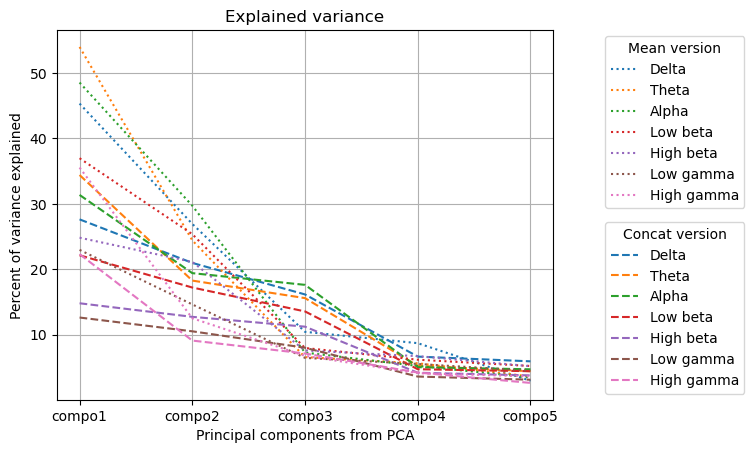

In [63]:
colors = plt.get_cmap('tab10')
element_colors = {elem: colors(i % 10) for i, elem in enumerate(FREQ_BAND)}
handles_concat = []
handles_mean = []

for band in FREQ_BAND:
    h_concat, = plt.plot(
        exp_var_concat.loc[(band)] * 100,
        label=band.capitalize().replace('_', ' '),
        color=element_colors[band],
        linestyle='--'
    )
    h_mean, = plt.plot(
        exp_var_mean.loc[(band)] * 100,
        label=band.capitalize().replace('_', ' '),
        color=element_colors[band],
        linestyle=':'
    )
    handles_concat.append(h_concat)
    handles_mean.append(h_mean)

plt.grid()
plt.title('Explained variance')
plt.xlabel('Principal components from PCA')
plt.ylabel('Percent of variance explained')

legend1 = plt.legend(handles=handles_concat, title='Concat version', loc='upper right', bbox_to_anchor = (1.4, 0.5))
legend2 = plt.legend(handles=handles_mean, title='Mean version', loc='lower right', bbox_to_anchor = (1.4, 0.5))
plt.gca().add_artist(legend1)
plt.show()


## COMPO ANALYSIS

In [64]:
nb_compo=3
grp_compo=pd.read_csv(f'{OUT_PATH}/grpPCA/supsubj_mean/grp_mean_compo_PCA{nb_compo}.csv').drop(columns = 'Unnamed: 0')

In [65]:
def CompoThr(data, replace=0) : 
    data_thr = data.copy()
    for i in range(data.shape[0]):
        thr = data[i,:].mean() + abs(data[i, :].std())      
        index_thr = np.where(abs(data[i, :]) < thr)
        data_thr[i, index_thr[0].flatten()] = replace

    return data_thr


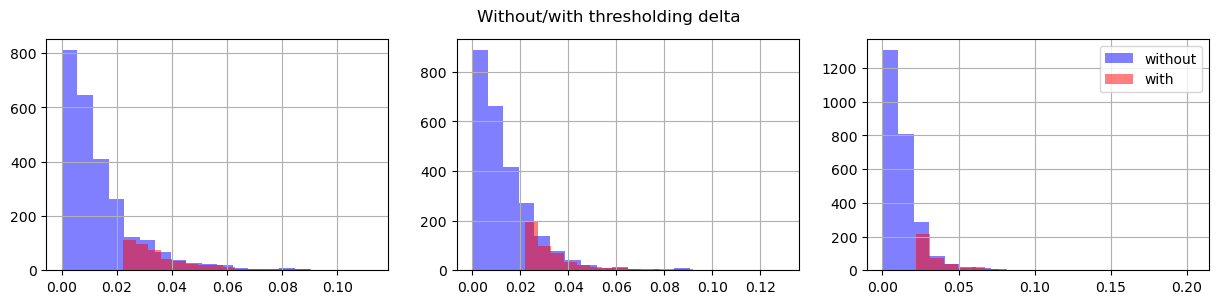

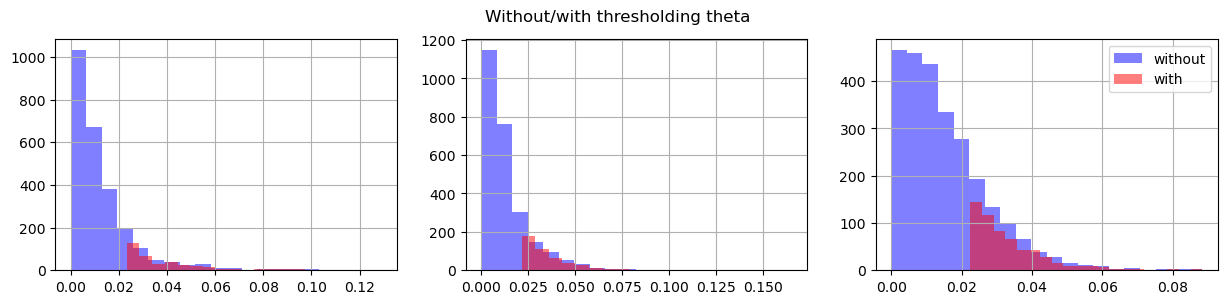

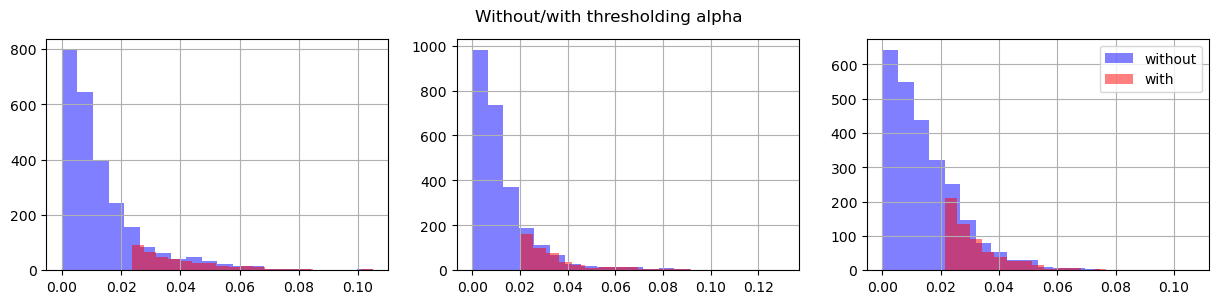

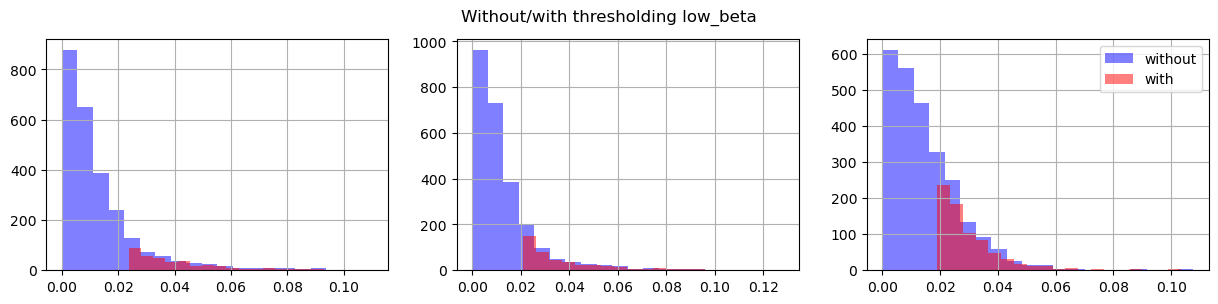

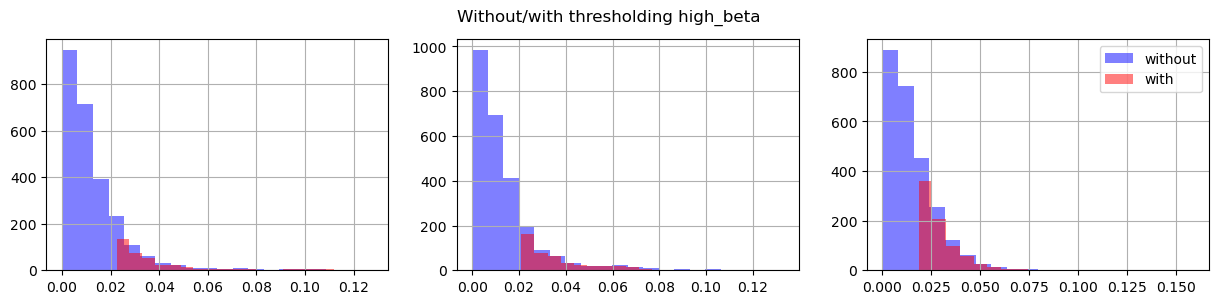

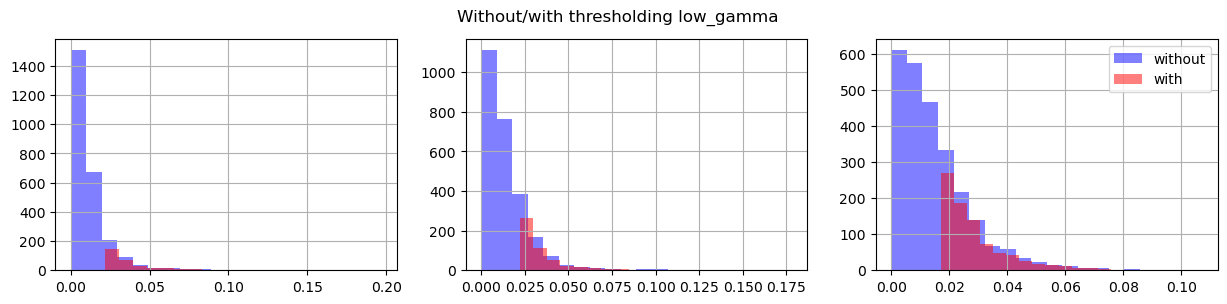

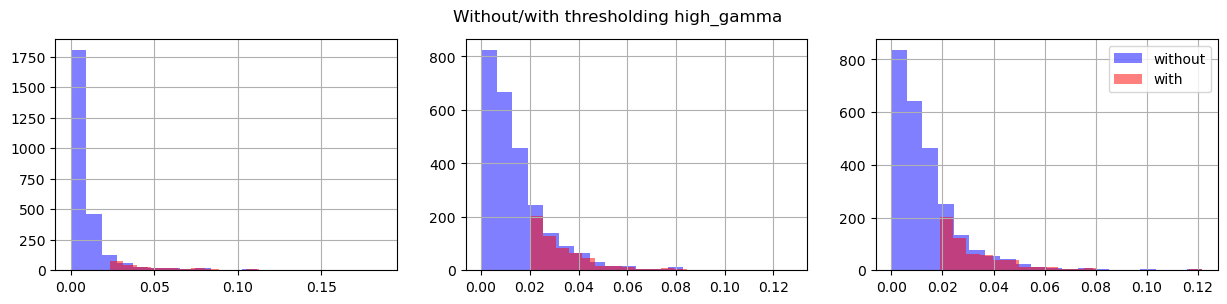

In [66]:
df_data_all={}

for band in FREQ_BAND :   
    data = grp_compo.query("freq == @band").drop(columns = ['compo', 'freq']).values
    data_thr = CompoThr(data)
    df_data = pd.DataFrame(np.concat([np.array(elect_list).reshape(len(elect_list), 1),np.array(areas)[:, 0].reshape(len(areas), 1), data_thr.T], axis = 1)).rename(columns = {0 : 'elect', 1: 'area', 2:1, 3:2, 4:3, 5:4, 6:5})
    df_data[[1, 2, 3]] = df_data[[1, 2, 3]].astype(float)
    df_data_all[band] = df_data

    # plt
    fig, axs = plt.subplots(1, nb_compo, figsize = (15, 3))
    fig.suptitle(f'Without/with thresholding {band}')
    df = grp_compo.query("freq == @band").set_index('compo').drop(columns = ['freq'])
    df_thr = pd.DataFrame(CompoThr(data, replace=np.nan)).T
    df_thr[[0, 1, 2]] = df_thr[[0, 1, 2]].astype(float)
    df_thr = df_thr.T
    df_thr['compo'] = ['compo' + str(i+1) for i in range(len(df_thr))]
    df_thr= df_thr.set_index('compo')

    for i, ax in enumerate(axs) : 
        df.loc['compo' + str(i+1), :].apply(lambda x : abs(x)).hist(bins=20, ax=ax, alpha = 0.5, color = 'blue', label = 'without')
        df_thr.loc['compo' + str(i+1), :].apply(lambda x : abs(x)).hist(bins=20, ax=ax, alpha = 0.5, color = 'red', label='with')   

    ax.legend()

#### Distribution

/tmp/ipykernel_12691/1987568863.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



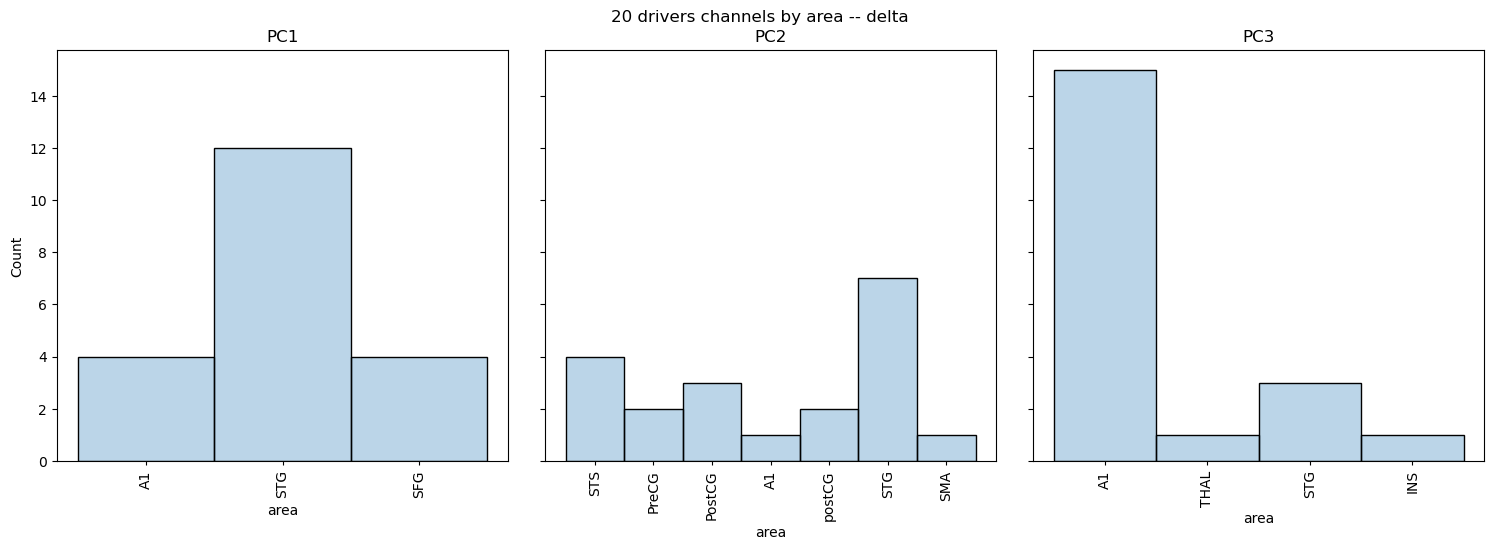

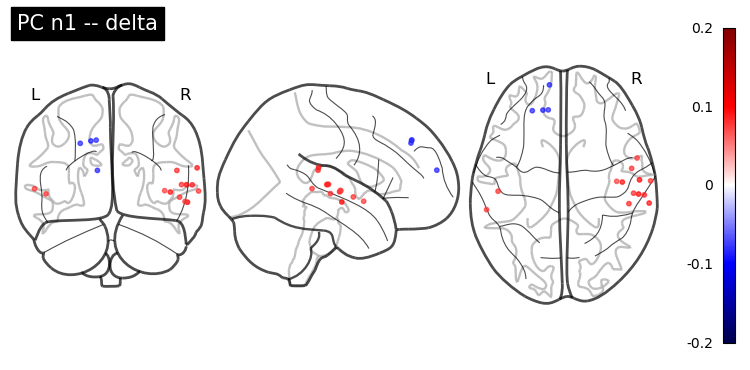

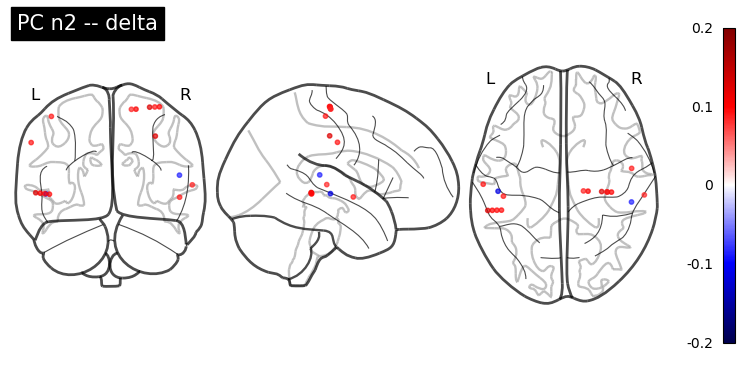

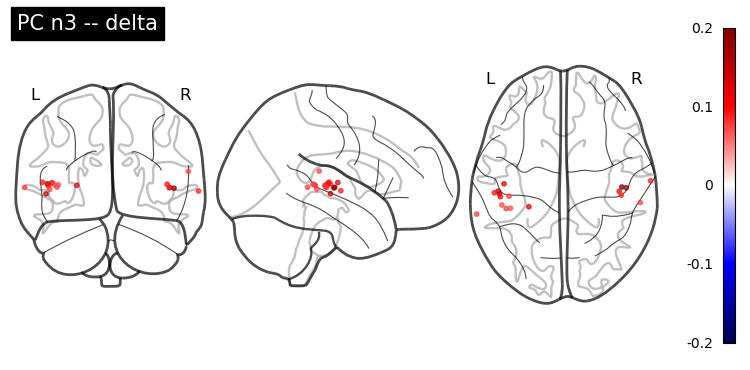

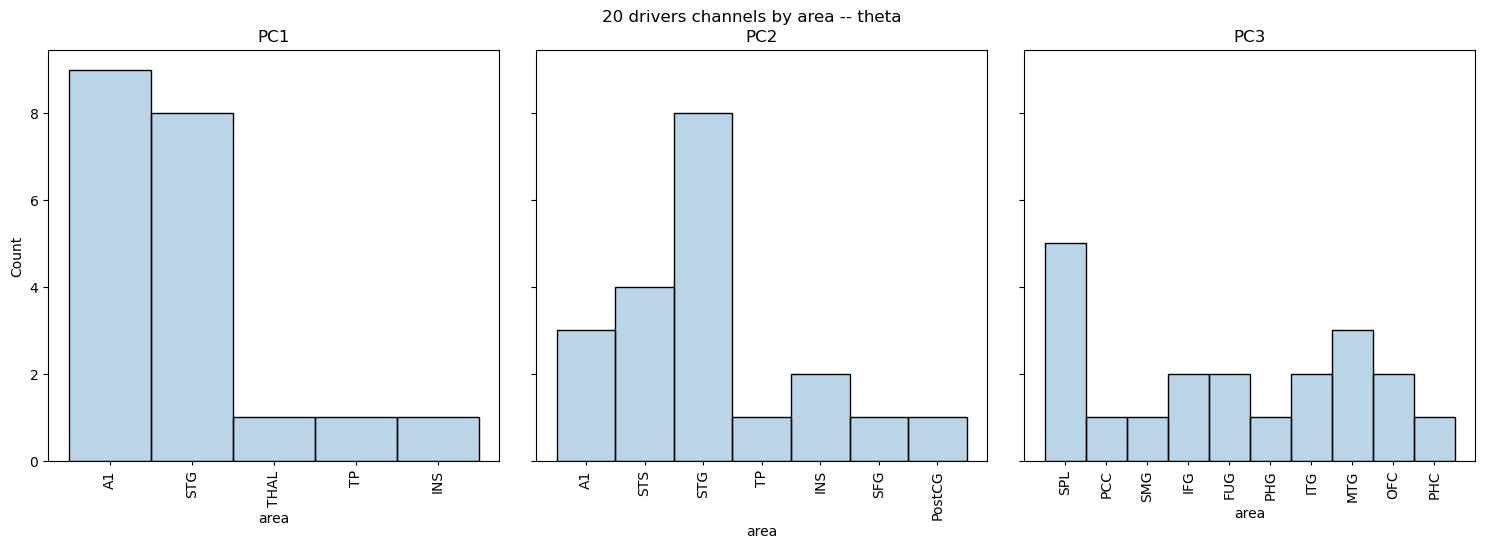

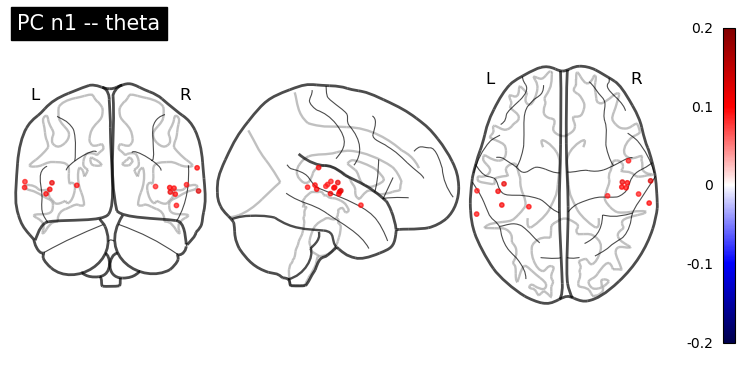

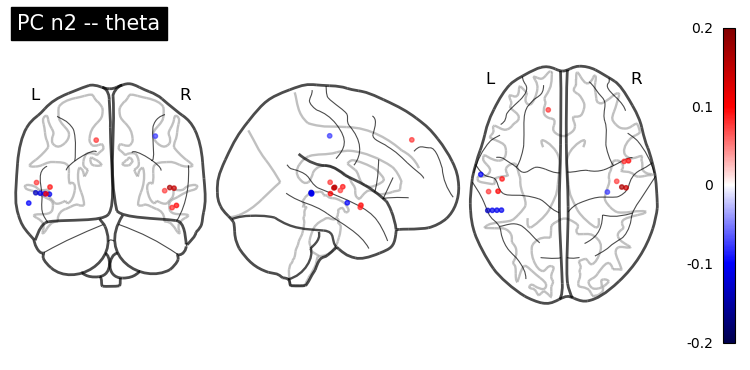

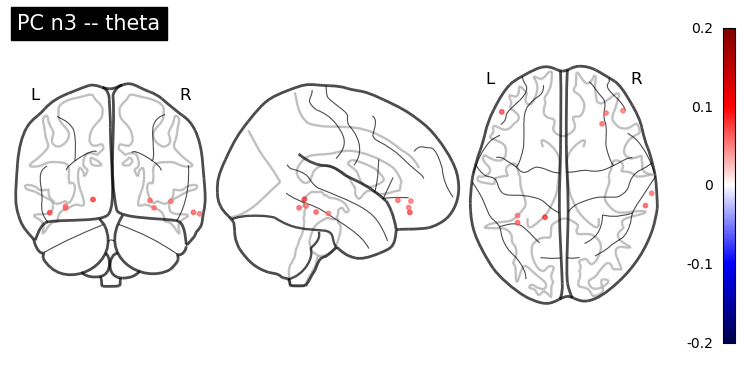

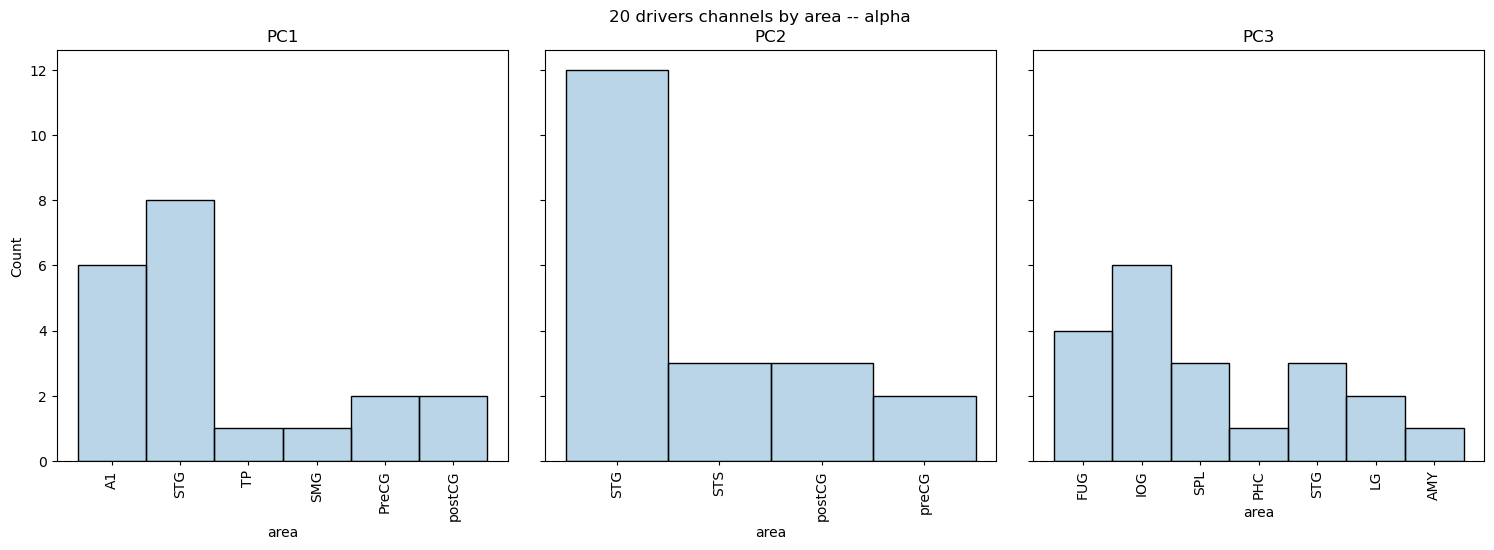

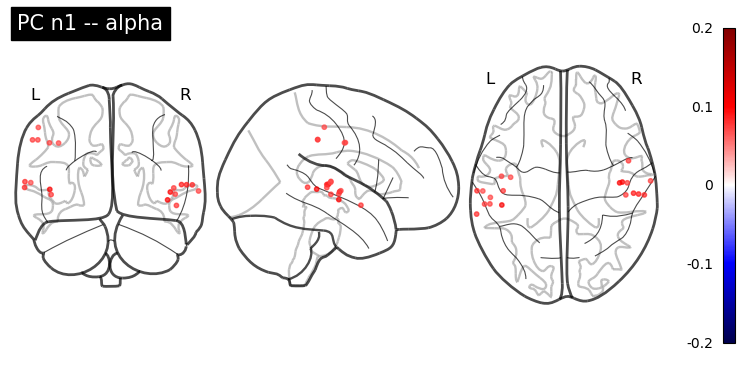

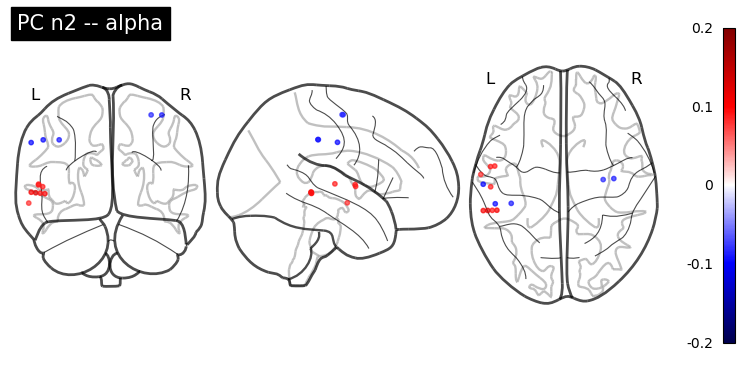

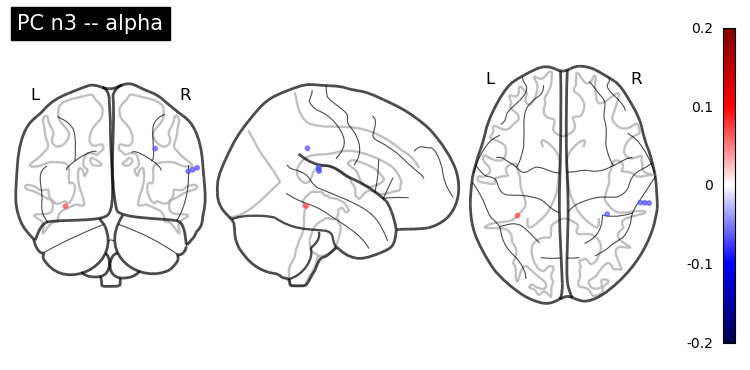

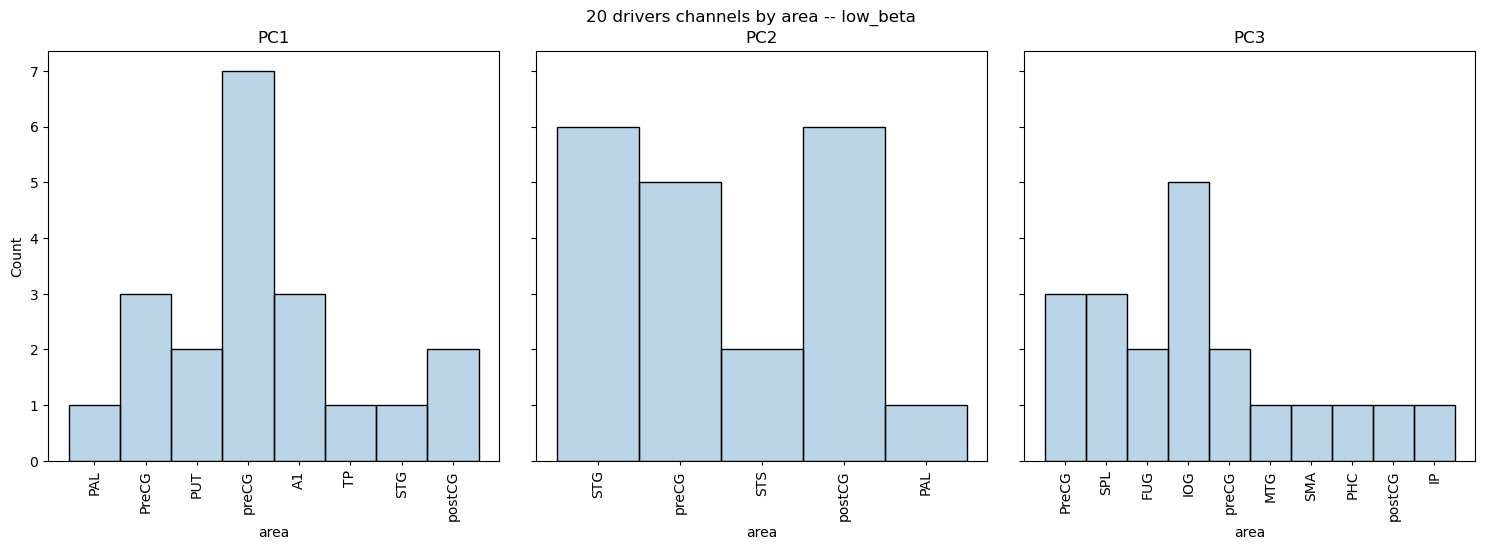

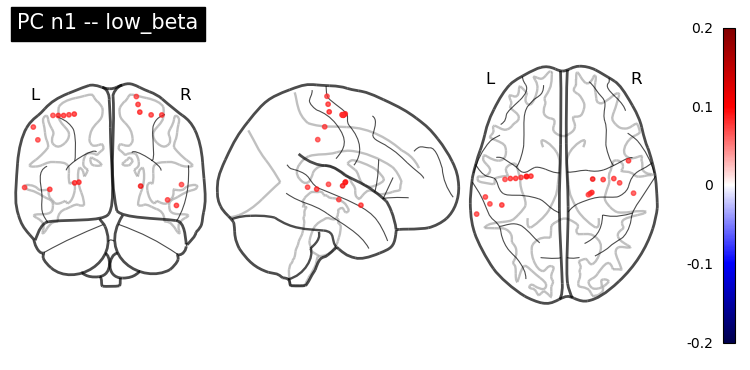

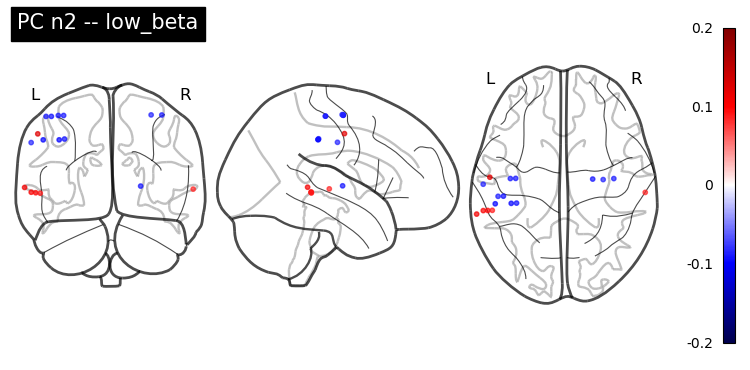

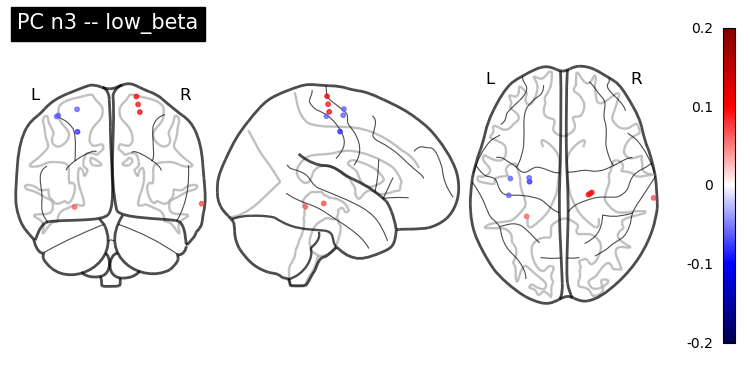

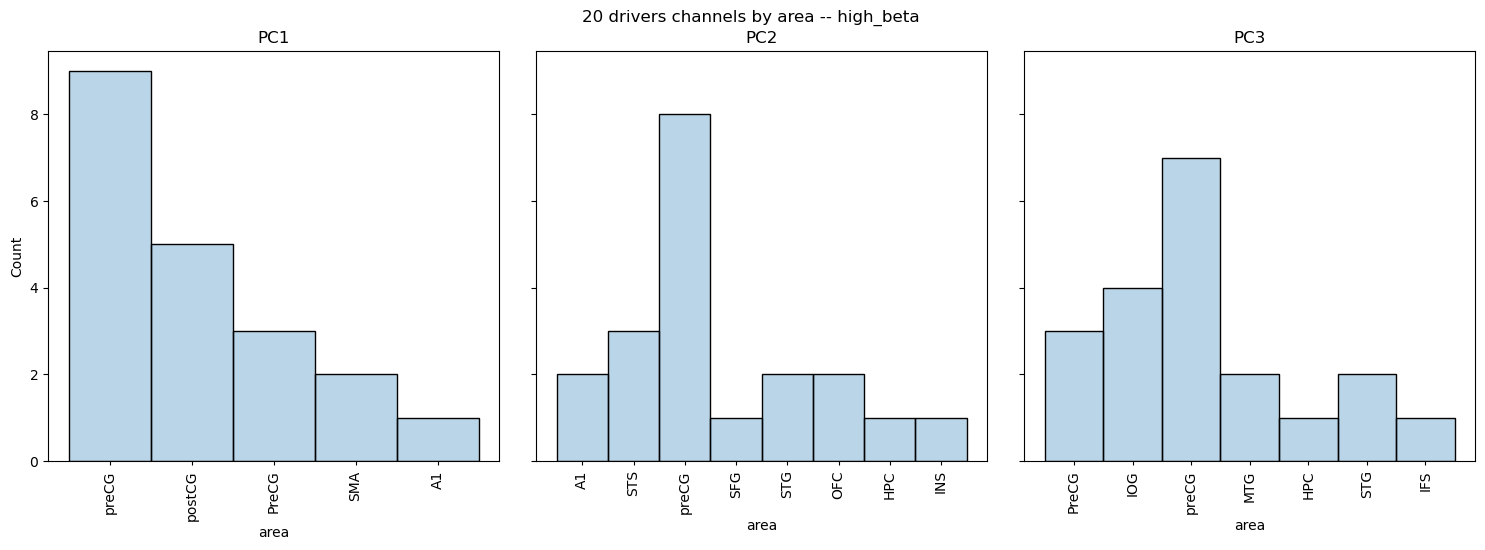

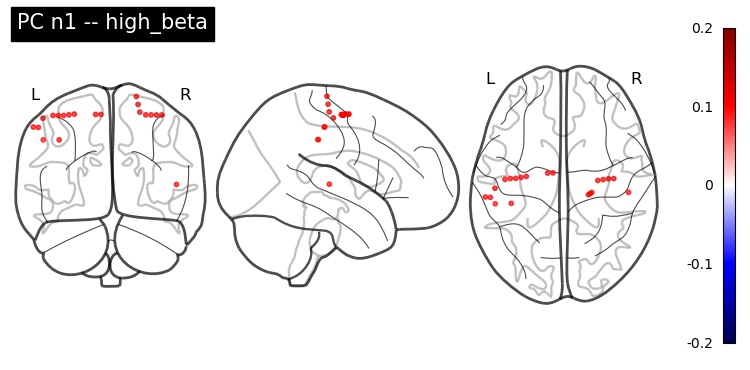

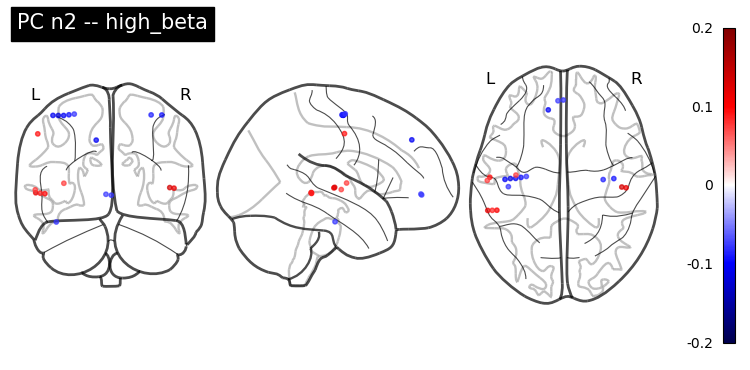

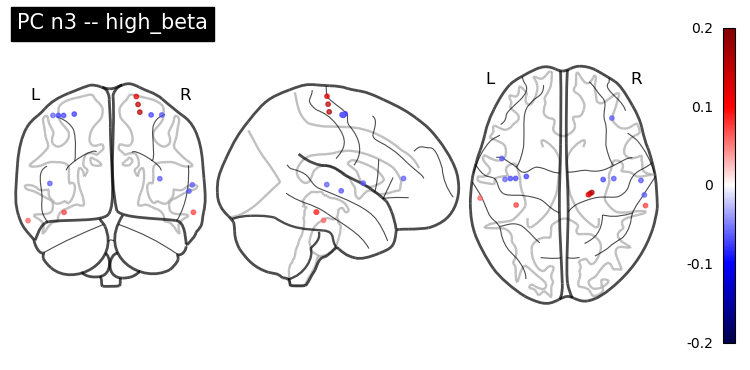

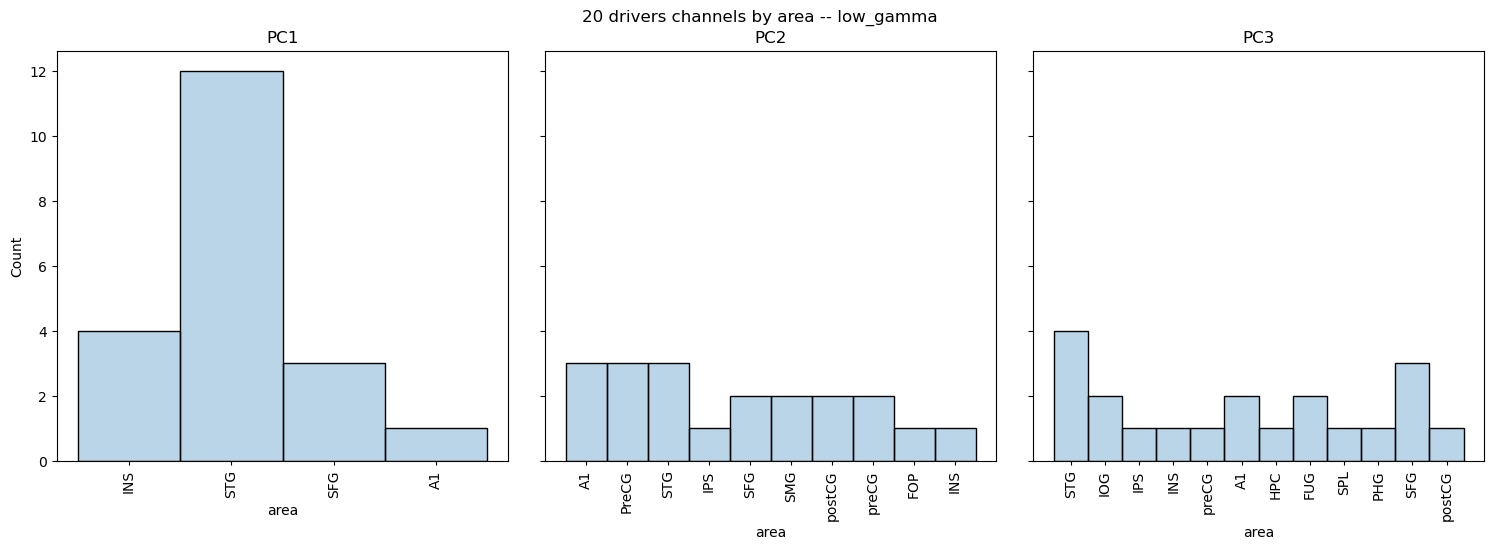

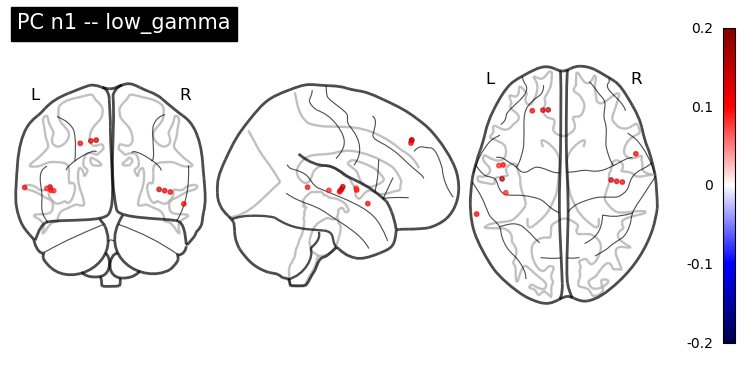

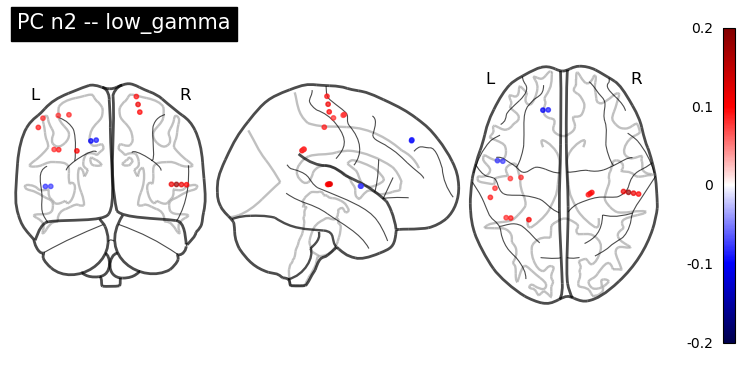

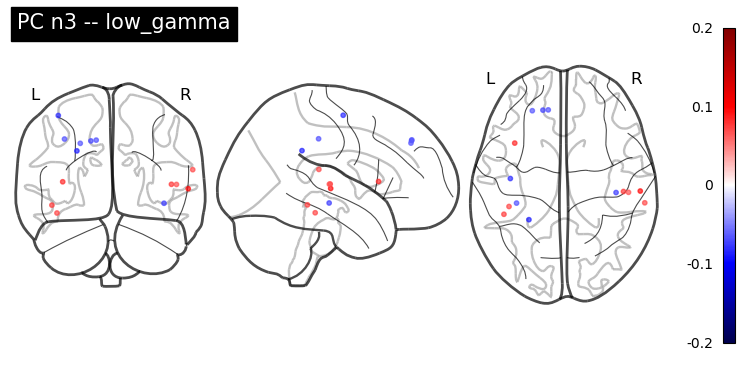

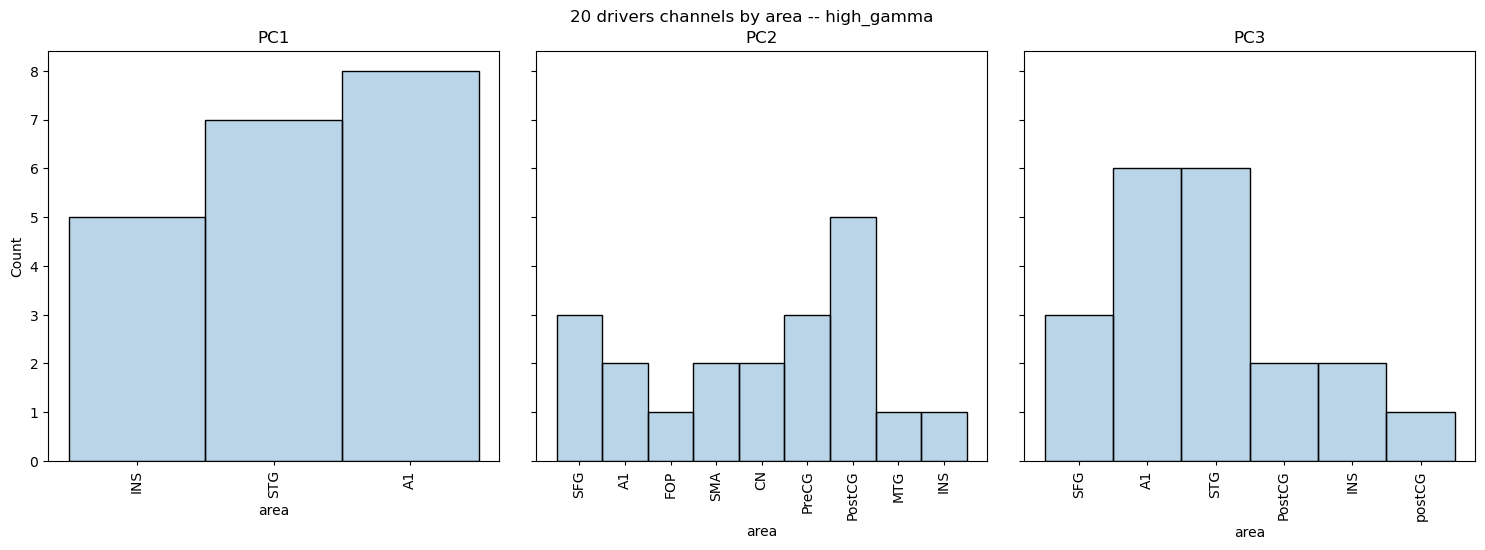

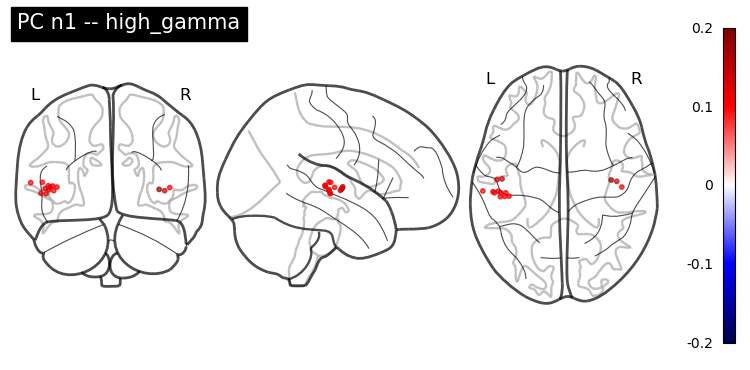

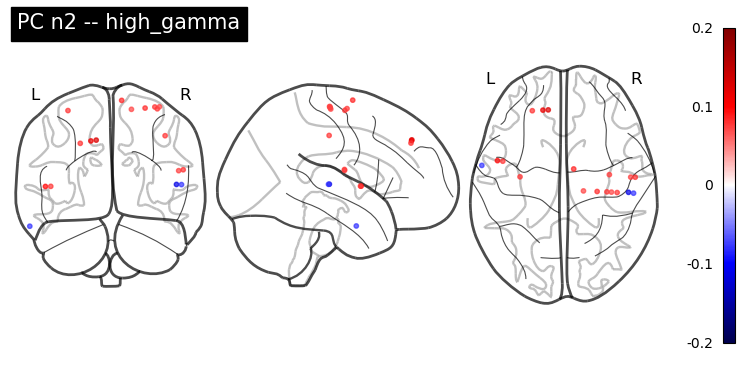

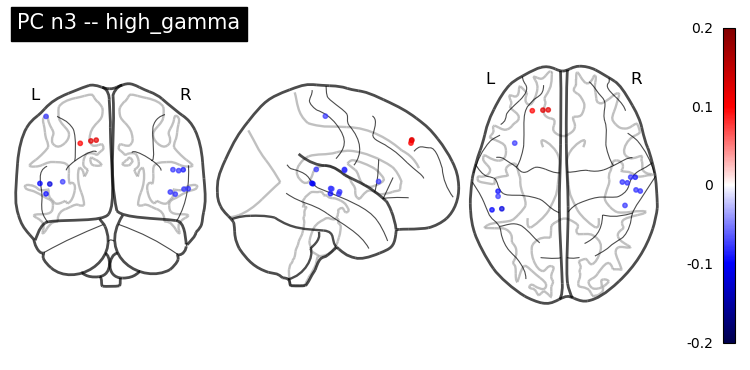

In [67]:
# Histo of the main drivers ones
nb_el = 20
largest_list={}
for band in FREQ_BAND :  
    df_data = df_data_all[band]
    fig, axs = plt.subplots(1, nb_compo, figsize = (15, 5), sharey=True)
    fig.suptitle(f'{nb_el} drivers channels by area -- {band}')
    fig.tight_layout()
    largest_list[band] = []
    for i, ax in enumerate(axs) : 
        largest = df_data.iloc[df_data[i+1].abs().nlargest(nb_el).index][['elect', 'area', i+1]]
        largest_list[band].append(largest)
        sns.histplot(largest, x= 'area', element='bars', alpha = 0.3, ax=ax)
        ax.tick_params(axis='x', rotation=90, size = 3)
        ax.set_title('PC' + str(i+1))

        fig1 = plotting.plot_markers(node_coords = coord_array[largest.index],  node_size=10, node_values=largest[i+1], node_cmap='seismic', title=f'PC n{i+1} -- {band}',display_mode='ortho', node_vmin=-0.2, node_vmax=0.2)

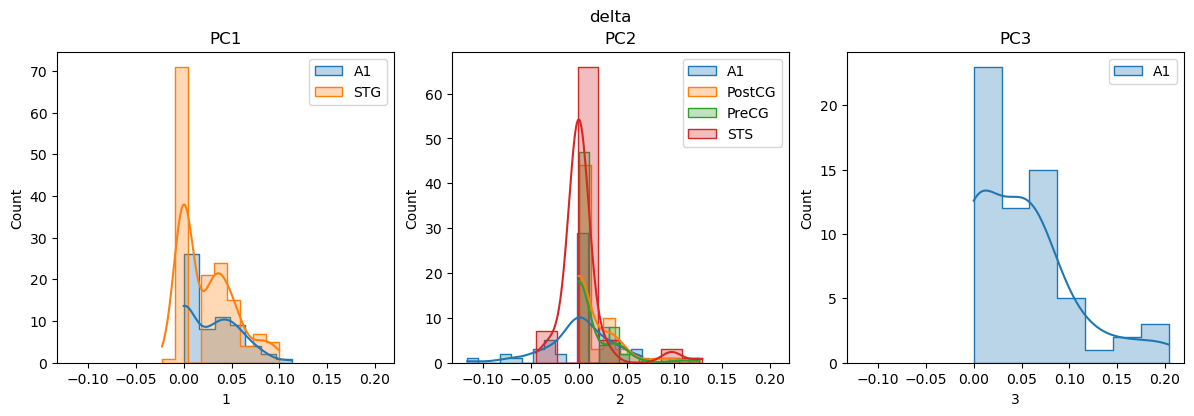

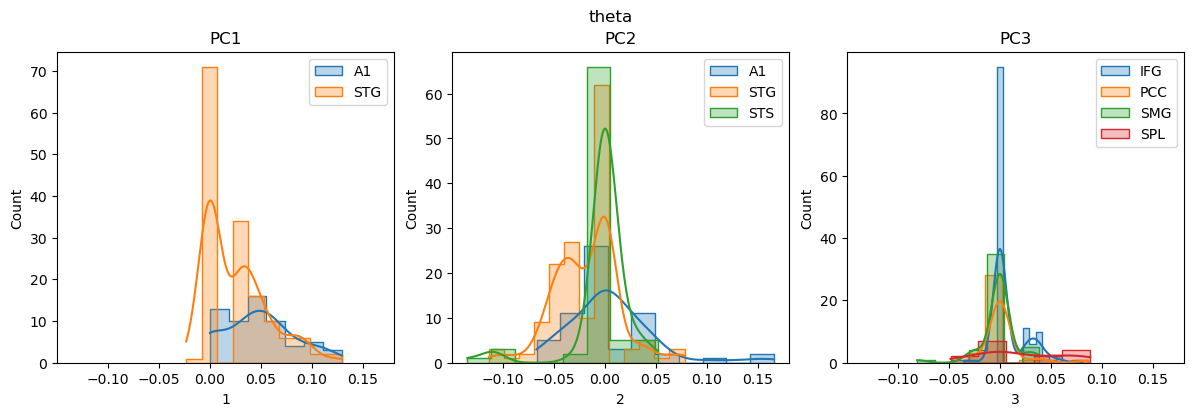

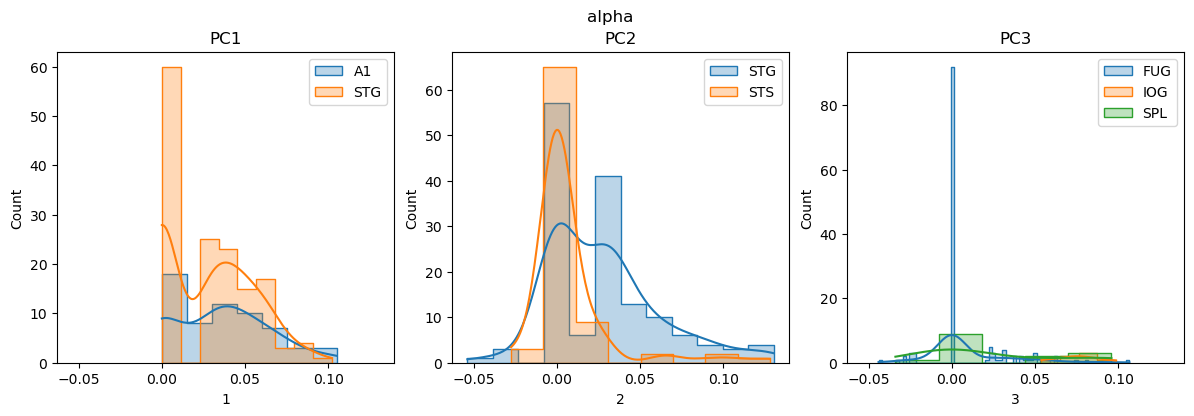

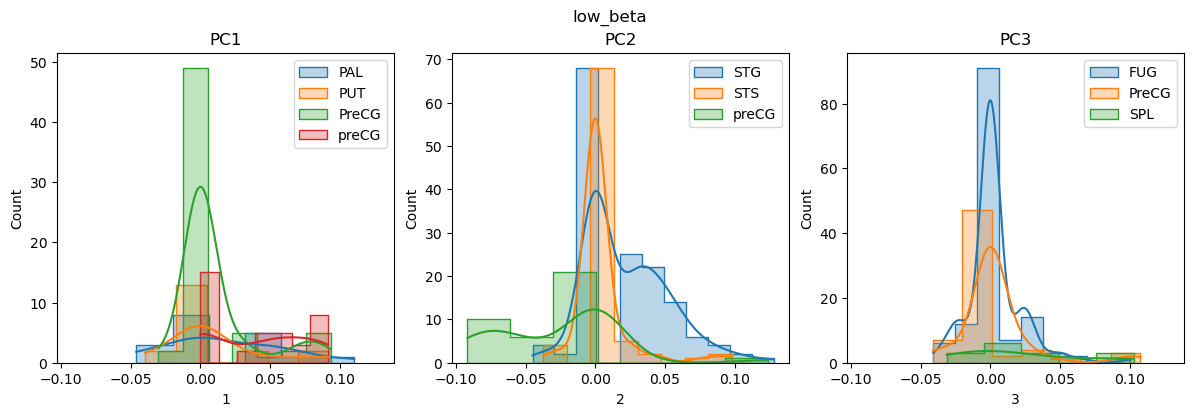

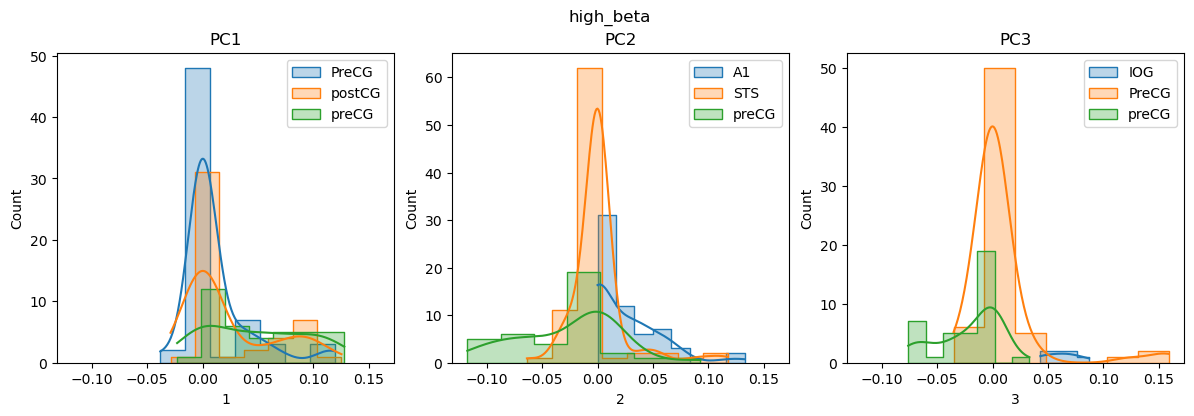

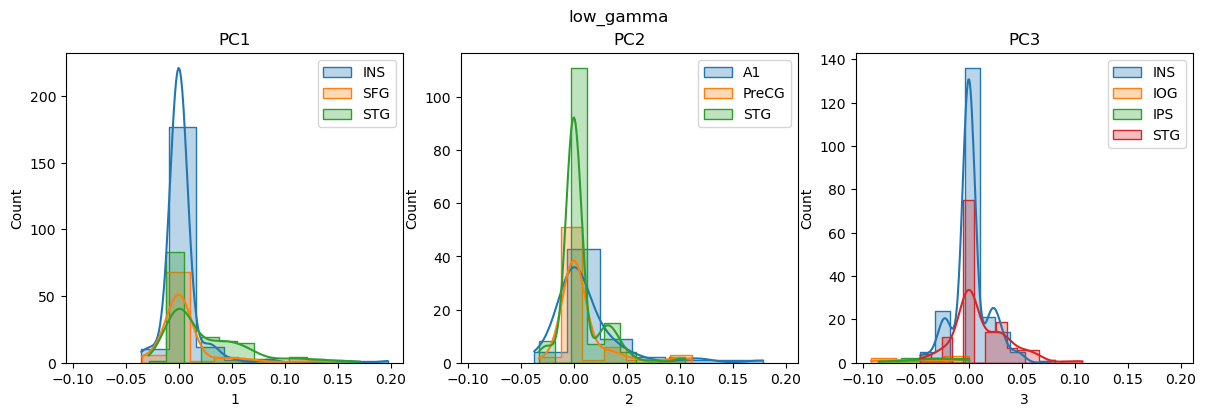

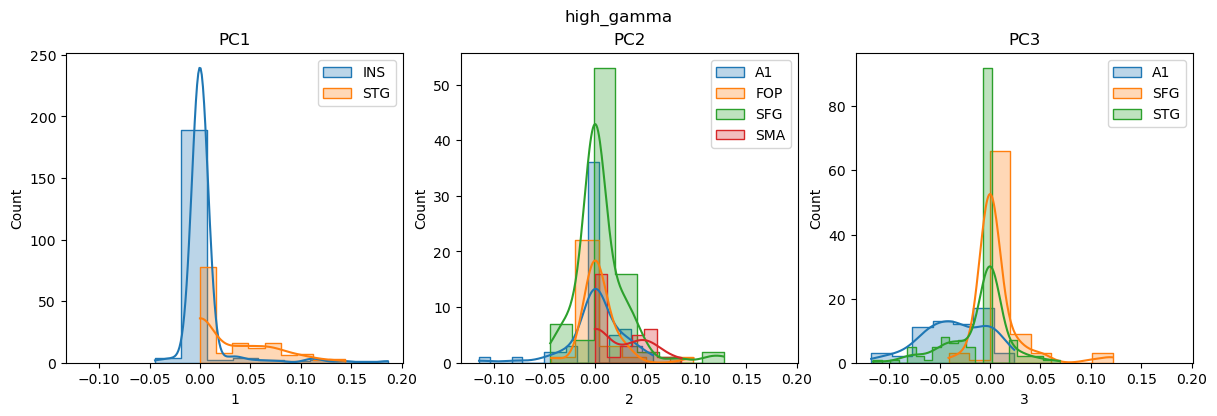

In [68]:
# Area selected distrib among PC

for band in FREQ_BAND :
    df_data = df_data_all[band]
    fig, ax = plt.subplots(1, nb_compo, figsize = (nb_compo*4, 4), sharex=True)
    fig.suptitle(band)
    fig.tight_layout()

    for i in range(nb_compo) : 
        area_list_PC = np.unique(largest_list[band][i].area[:5].dropna())
        for area in area_list_PC :  
            sns.histplot(df_data.set_index('area').loc[area, i+1], stat='count', element='step', ax= ax[i], kde=True, alpha = 0.3, fill=True, label = area)
        ax[i].set_title('PC' + str(i+1))
        ax[i].legend()
    plt.show()

    '''
    fig, ax = plt.subplots(1, len(area_list), figsize = (len(area_list)*4, 4), sharex=True)
    fig.suptitle(band)
    fig.tight_layout()

    for i, area_selec in enumerate(area_list) :  
        sns.histplot(df_data.set_index('area').loc[area_selec], stat ='count', element='step', ax= ax[i], kde=True, alpha = 0.3, fill=True)
        ax[i].set_title(area_selec)
    plt.show()

    fig, ax = plt.subplots(1, nb_compo, figsize = (nb_compo*4, 4), sharex=True)
    fig.suptitle(band)
    fig.tight_layout()

    for i in range(nb_compo) : 
        for area in area_list :  
            sns.histplot(df_data.set_index('area').loc[area, i+1], stat='percent', element='step', ax= ax[i], kde=True, alpha = 0.3, fill=True, label = area)
        ax[i].set_title('PC' + str(i+1))
        ax[i].legend()
    plt.show()
    '''

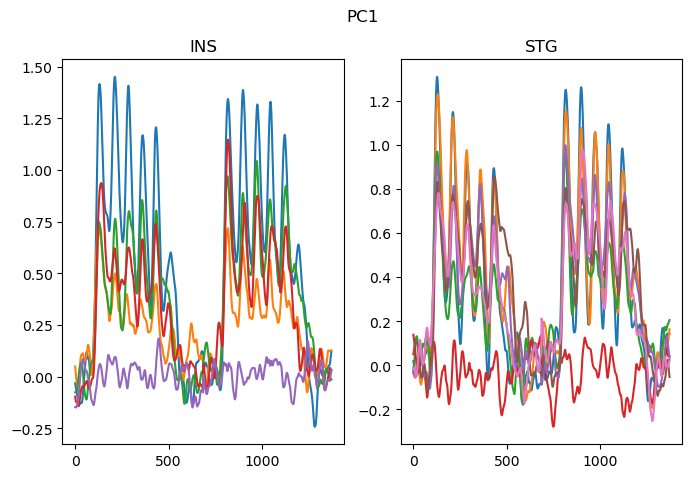

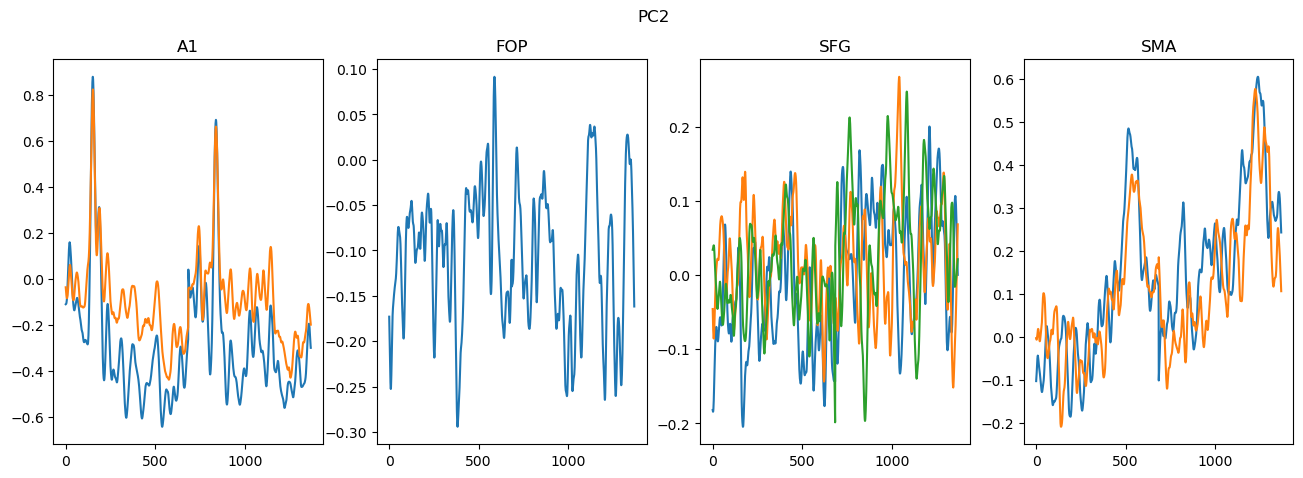

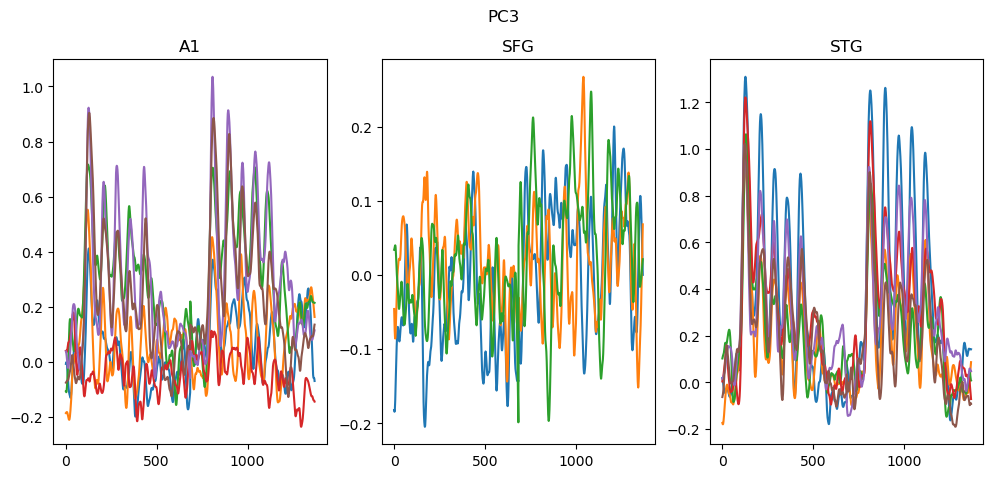

In [69]:
# Check the raw
for i in range(nb_compo) :
    area_to_check = np.unique(largest_list[band][i].area[:5].dropna())
    fig, axs = plt.subplots(1, len(area_to_check), figsize= (len(area_to_check)*4, 5))
    fig.suptitle('PC' + str(i+1))
    for ax, area in zip(axs,area_to_check) : 
        largest = largest_list[band][i]
        elect_to_check = largest[largest['area'] == area].elect
        id_elect_to_check = [elect_list.index(el) for el in elect_to_check] 
        ax.plot(concat_all[id_elect_to_check,6, :].T)
        ax.set_title(area)

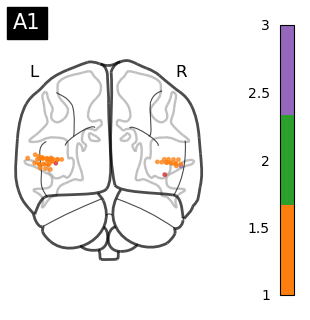

In [70]:
# CHECK MY LABELS -- Color per componant invovled the most
band = 'high_gamma'
df_data = df_data_all[band]
base_cmap = plt.cm.tab10  
colors = [base_cmap(i+1) for i in range(4)]
custom_cmap = ListedColormap(colors, name=f'tab5')

area_list = ['A1']

for area in area_list : 
    id_area = df_data[df_data['area'] == area].index
    label = df_data[df_data['area'] == area][[1, 2, 3]].idxmax(axis=1).values
    fig1 = plotting.plot_markers(node_coords = coord_array[id_area],  node_size=6, node_values=label, node_cmap=custom_cmap, title=area,display_mode='y')


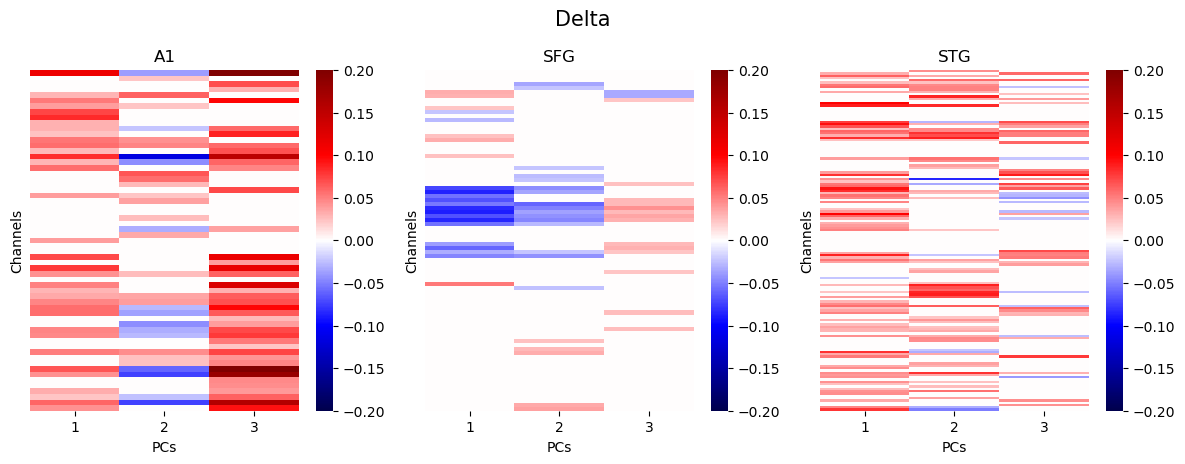

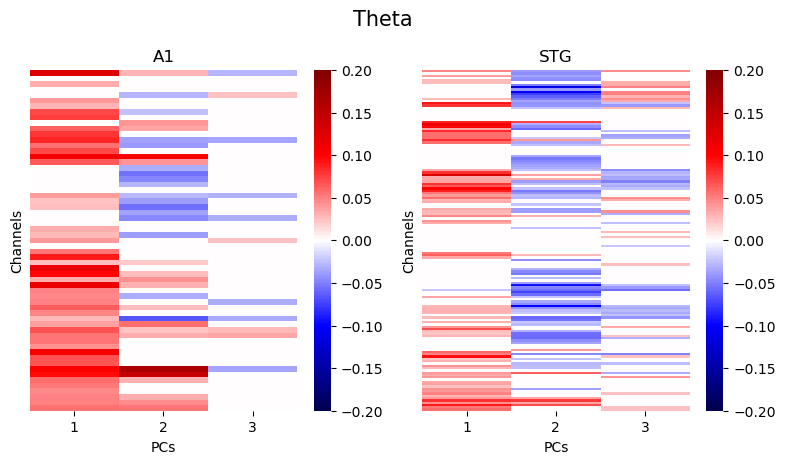

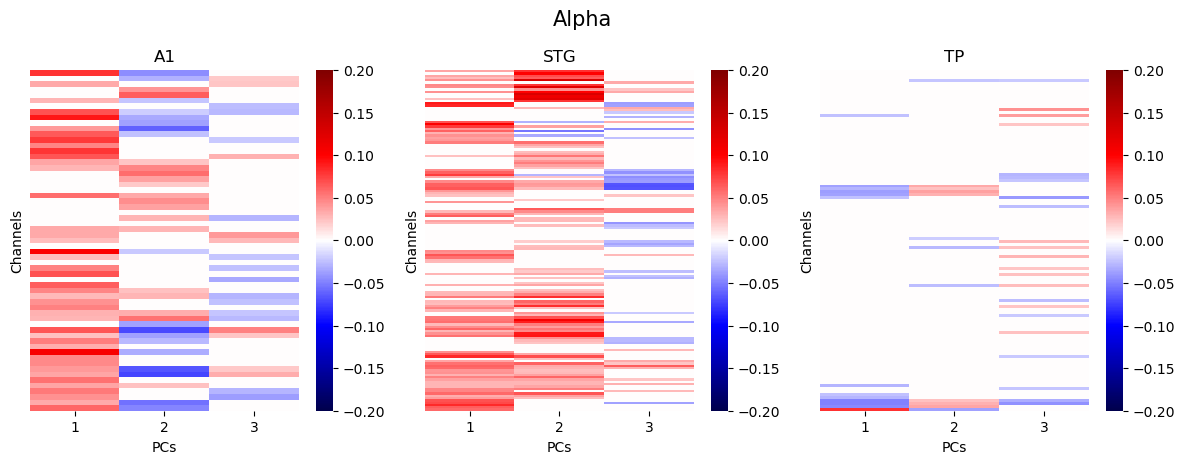

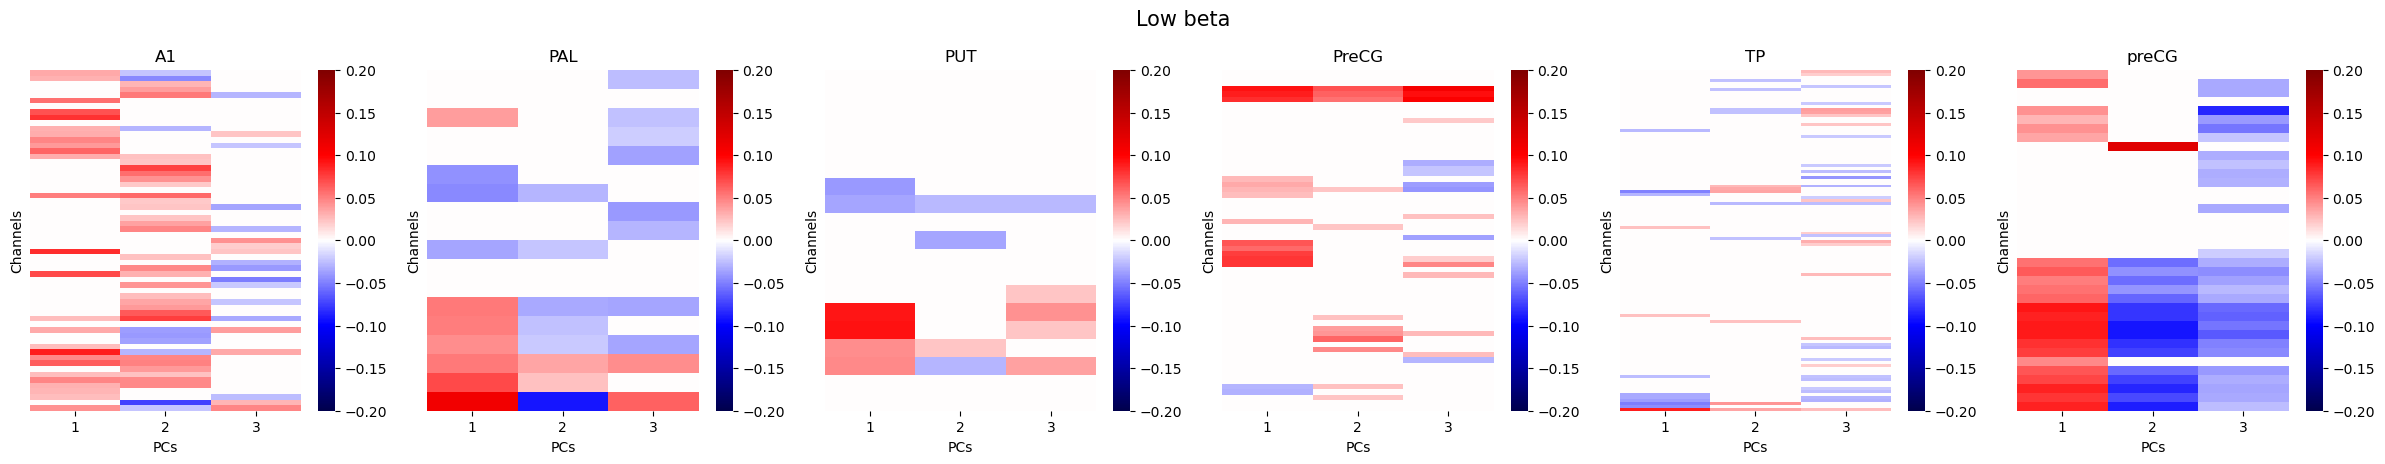

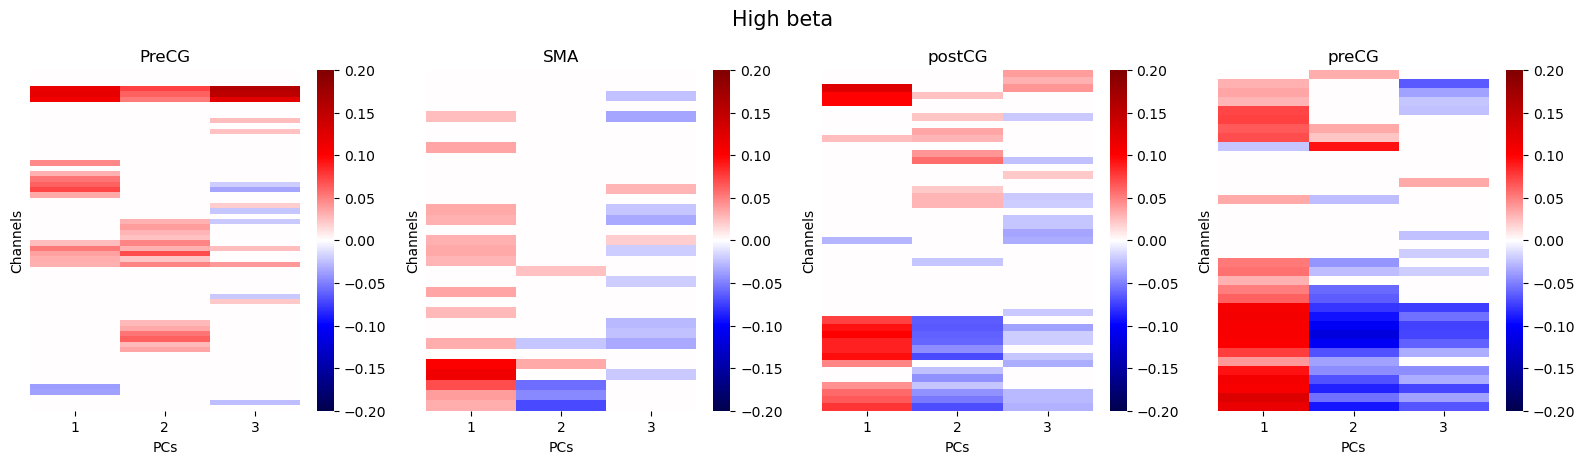

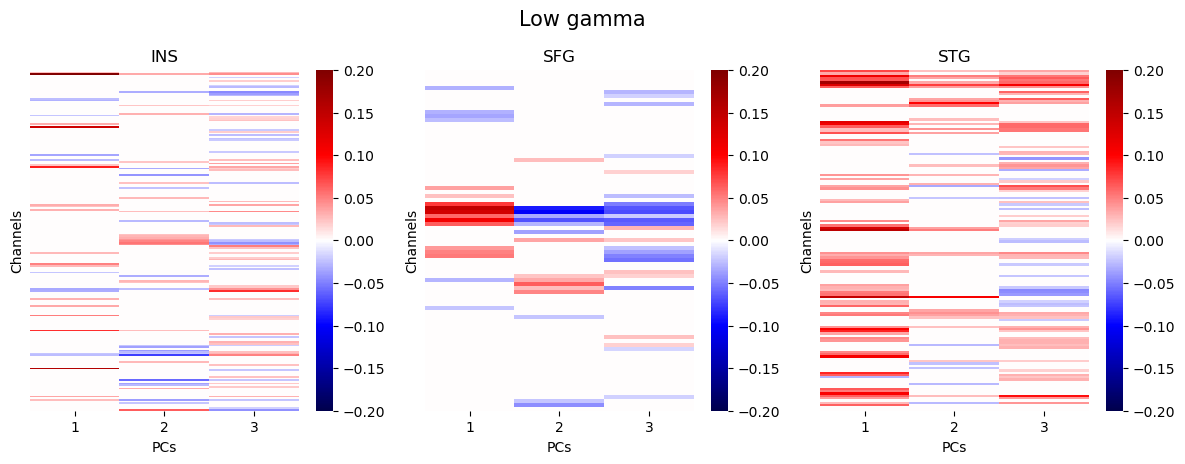

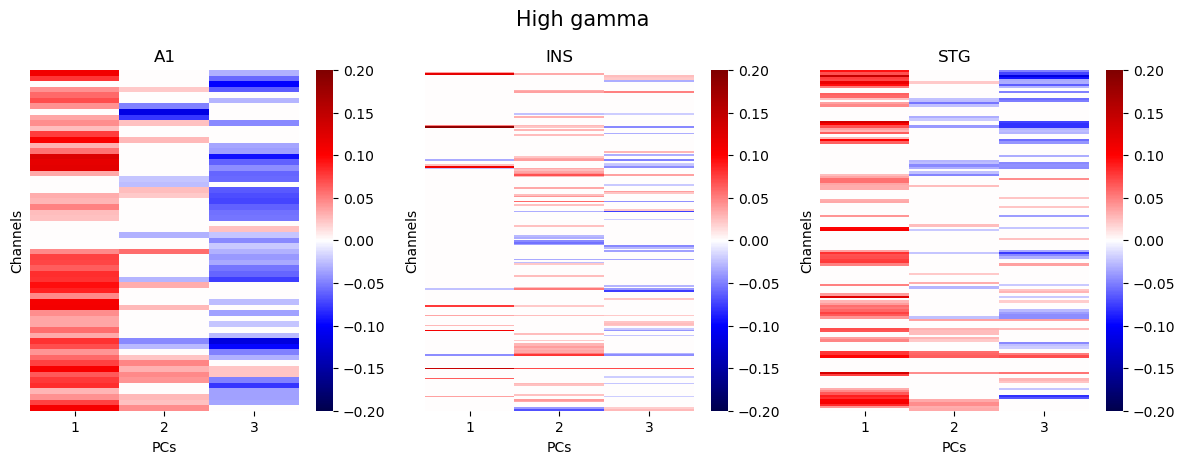

In [71]:
# heatmap of the channels distribution
for band in FREQ_BAND:
    area_to_check = np.unique(largest_list[band][0].area[:10].dropna())

    fig, ax = plt.subplots(1, len(area_to_check), figsize = (len(area_to_check)*4, 4))
    fig.tight_layout()
    fig.suptitle(band.capitalize().replace('_', ' '), y= 1.1, size=15)
    vlim = 0.2
    df_data =df_data_all[band]

    for i, area_selec in enumerate(area_to_check) :  
        df_subset = df_data[df_data['area'] == area_selec]
        sns.heatmap(df_subset.drop(columns = ['elect', 'area']), center = 0, vmax = 0.2, vmin = -0.2, cmap = 'seismic', ax= ax[i], yticklabels=False)
        ax[i].set_title(area_selec)
        ax[i].set_ylabel('Channels')
        ax[i].set_xlabel('PCs')


Text(0.5, 1.0, 'PCA ')

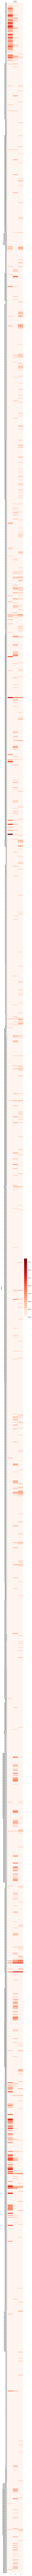

In [72]:
vlim = np.max(df_data.drop(columns ='area').set_index('elect'))
fig, ax = plt.subplots(figsize = (3, 300))
fig.tight_layout()
sns.heatmap(df_data.sort_values('area').drop(columns ='area').set_index('elect'), vmin= 0, vmax = vlim, cmap = 'Reds', ax= ax, yticklabels=df_data.sort_values('area').drop(columns ='elect').area)
ax.set_title('PCA ')

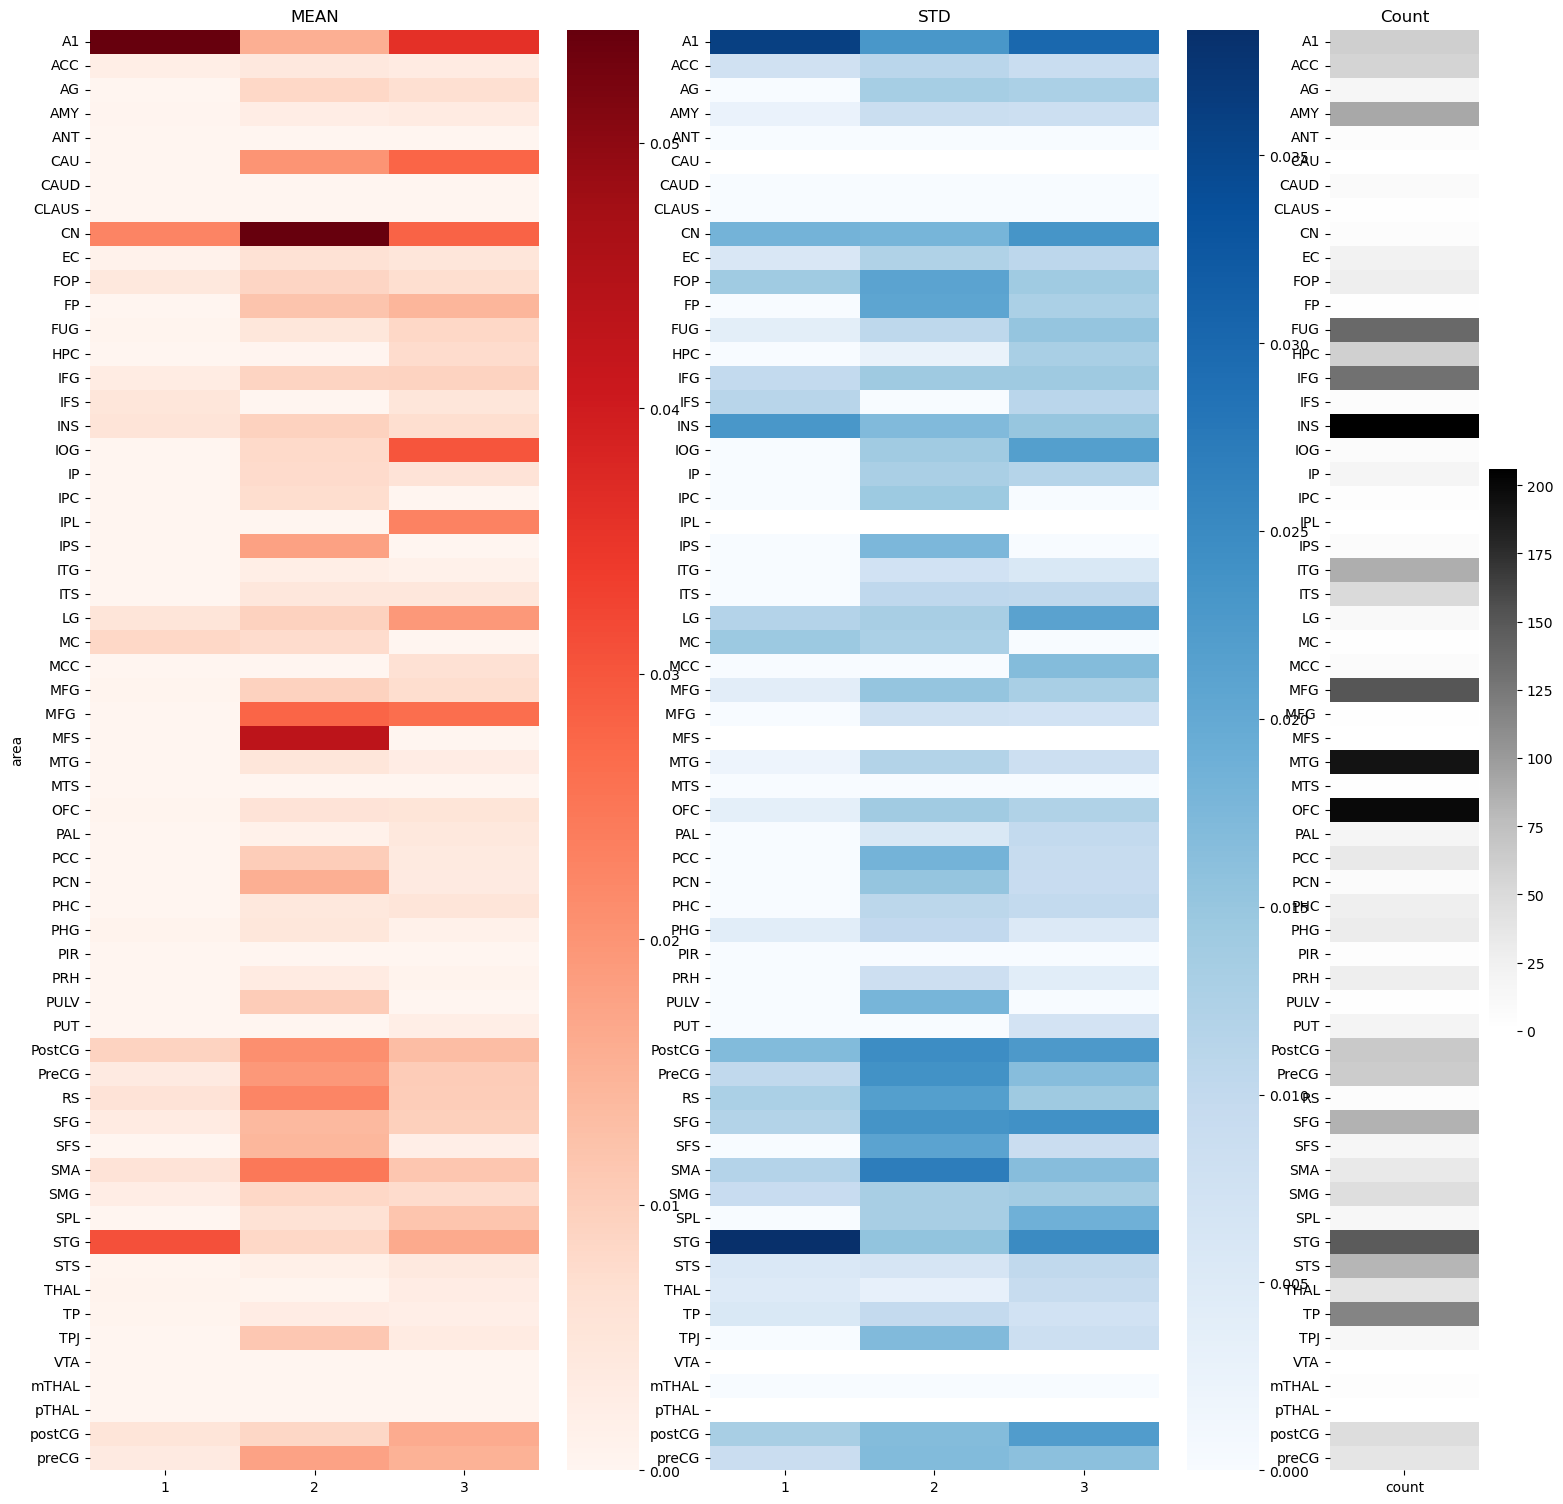

In [73]:
vlim = np.max(df_data.drop(columns ='elect').groupby('area').mean())

df_data.loc[:, [1, 2, 3]] = df_data.loc[:, [1, 2, 3]].apply(lambda x : np.abs(x))

fig, ax = plt.subplots(1, 3, figsize = (15, 15), width_ratios=[3/7, 3/7, 1/7])
fig.tight_layout()
sns.heatmap(df_data.drop(columns ='elect').groupby('area').mean(), vmin= 0, vmax = vlim, cmap = 'Reds', ax= ax[0], yticklabels=df_data.drop(columns ='elect').groupby('area').mean().index)
ax[0].set_title('MEAN')

vlim = np.max(df_data.drop(columns ='elect').groupby('area').std())
sns.heatmap(df_data.drop(columns ='elect').groupby('area').std(), vmin= 0, vmax = vlim, cmap = 'Blues', ax= ax[1], yticklabels=df_data.drop(columns ='elect').groupby('area').std().index)
ax[1].set_ylabel('')
ax[1].set_title('STD')

vlim = np.max(df_data['area'].value_counts())
count = pd.DataFrame(df_data['area'].value_counts(sort=False))
count = count.loc[df_data.drop(columns ='elect').groupby('area').std().index]

sns.heatmap(count, vmin= 0, vmax = vlim, cmap = 'Greys', ax= ax[2], yticklabels=count.index)
ax[2].set_ylabel('')
ax[2].set_title('Count')

plt.show()

### Clustering 

In [74]:
# run kmean clustering on each freq bar and find the optimal numer of clusters
ncl_best = {}
sil_score = {}
labels = pd.DataFrame()
for band in FREQ_BAND : 
    data = grp_compo.query("freq == @band").drop(columns = ['compo', 'freq']).values
    weight_data_b = CompoThr(data, replace = 0).T
    scaler = StandardScaler(with_std=False, with_mean=False)
    weight_data_b = scaler.fit_transform(weight_data_b)
    
    silhouette_avg = []
    range_n_clusters = np.arange(2, 10)
    for n_clusters in range_n_clusters : 
        cl = KMeans(n_clusters)
        cl.fit(weight_data_b)
        cluster_labels = cl.labels_
        silhouette_avg.append(silhouette_score(weight_data_b, cluster_labels))
    ncl_best[band] = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
    sil_score[band] = max(silhouette_avg)
    kmean = KMeans(ncl_best[band]).fit(weight_data_b)
    labels[band] = kmean.labels_.T

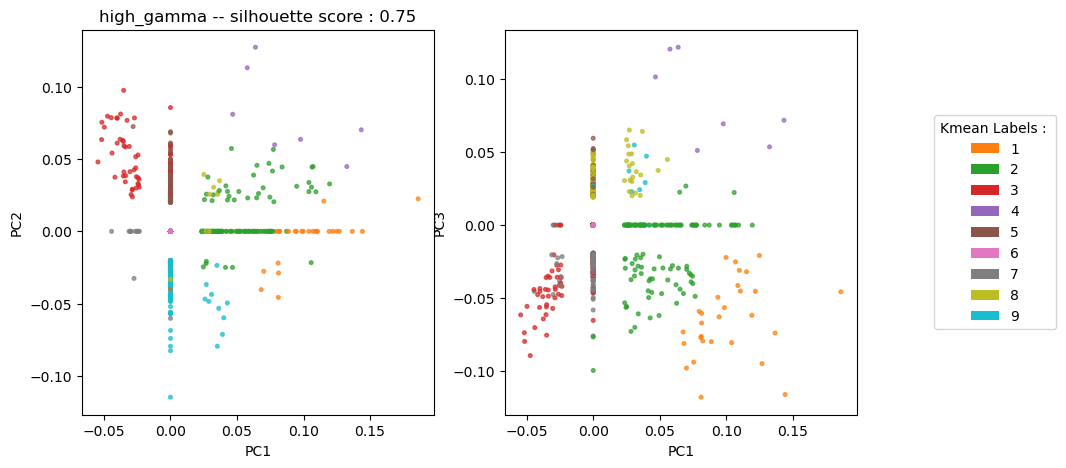

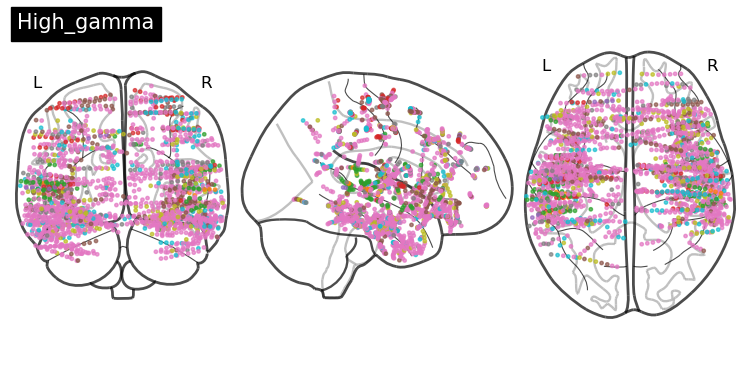

In [91]:
tfr_path = OUT_PATH + '/Data'
project_path = PROJECT_PATH 

base_cmap = plt.cm.tab10  

for i_b, band in enumerate(FREQ_BAND) : 
    if band == 'high_gamma' :
        fig, ax = plt.subplots(1, nb_compo-1, figsize = ((nb_compo-1)*5, 5))
        data = grp_compo.query("freq == @band").drop(columns = ['compo', 'freq']).values
        weight_data_b = CompoThr(data, replace = 0).T
        scaler = StandardScaler(with_std=False, with_mean=False)
        weight_data_b = scaler.fit_transform(weight_data_b)
        weight_data_b_c1 = weight_data_b[:, 0]

        idx = np.where(labels[band] >=0)[0]
        colors = [base_cmap(i) for i in np.unique(labels[band][idx])]
        custom_cmap = ListedColormap(colors, name=f'tab20_{len(np.unique(labels[band][idx]))}')
        legend_elements = [Patch(facecolor=custom_cmap(i / len(np.unique(labels[band]))), label=str(lbl)) for i, lbl in enumerate(np.unique(labels[band]))]

        for sec_pc in range(nb_compo-1) : 
            weight_data_b_sec = weight_data_b[:, sec_pc +1].T
            ax[sec_pc].scatter(weight_data_b_c1,weight_data_b_sec, c= labels[band], cmap=custom_cmap, alpha=0.7, s=7)
            ax[sec_pc].set_xlabel('PC1')
            ax[sec_pc].set_ylabel('PC' + str(sec_pc+2))
        legend_elements = [Patch(facecolor=custom_cmap(i / len(np.unique(labels[band]))), label=str(lbl)) for i, lbl in enumerate(np.unique(labels[band]))]

        fig = plotting.plot_markers(node_coords=coord_array[idx],node_values=labels[band][idx],node_size=6,node_cmap=custom_cmap,title=band.capitalize(),display_mode='ortho', colorbar=False)
        ax[sec_pc].legend(handles=legend_elements, title="Kmean Labels : ", bbox_to_anchor=(1.2, 0.5), loc='center left')
        ax[0].set_title(band + ' -- silhouette score : ' + str(np.round(sil_score[band], 2)))

        colors = [tuple(custom_cmap(val)) for val in labels[band].flatten()]
        view = plotting.view_markers(coord_array, marker_color=colors,marker_size=5,title=band, title_fontsize=25 )
        view.open_in_browser()

In [76]:
PC1 = weight_data_b[:, 0]
PC2 = weight_data_b[:, 1]
PC3 = weight_data_b[:, 2]
idx = np.where(labels[band] >=0)[0]
unique_lbls = np.unique(labels[band][idx])
colors = [base_cmap(i) for i in unique_lbls]
custom_cmap = ListedColormap(colors, name=f'tab20_{len(unique_lbls)}')
df = pd.DataFrame({'PC1': PC1[idx],'PC2': PC2[idx],'PC3': PC3[idx],'cluster': labels[band][idx].astype(str)})
fig = px.scatter_3d(df,x='PC1', y='PC2', z='PC3',color='cluster',opacity=0.7)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title=f'{band} — silhouette score: {np.round(sil_score[band], 2)}',scene=dict(xaxis_title='PC1',yaxis_title='PC2',zaxis_title='PC3'))
#fig.write_html(f"{OUT_PATH}/grpPCA/supsubj_concat/PC_{band}.html")

In [77]:
cls_to_try  = np.arange(2, 10)

labels={}
for freq_band_id in FREQ_BAND :
    data = grp_compo.query("freq == @freq_band_id").drop(columns = ['compo', 'freq']).values
    weight_data_b = CompoThr(data, replace = 0).T
    scaler = StandardScaler(with_std=False, with_mean=False)
    weight_data_b = scaler.fit_transform(weight_data_b)

    Z = linkage(weight_data_b, method='ward', metric='euclidean')
    
    # optimize number cluster 
    silhouette_scores = []
    for k in cls_to_try:
        l = fcluster(Z, k, criterion='maxclust')
        sil = silhouette_score(weight_data_b, l)
        silhouette_scores.append(sil)
 
    k = cls_to_try[silhouette_scores.index(max(silhouette_scores))]
    print(freq_band_id, max(silhouette_scores))
    # run 
    labels[freq_band_id] = fcluster(Z, k, criterion='maxclust')


delta 0.7481932786445584
theta 0.7282621622150399
alpha 0.7079988701397177
low_beta 0.7201731950326612
high_beta 0.6907310845210218
low_gamma 0.6698589833457842
high_gamma 0.7551030464442386


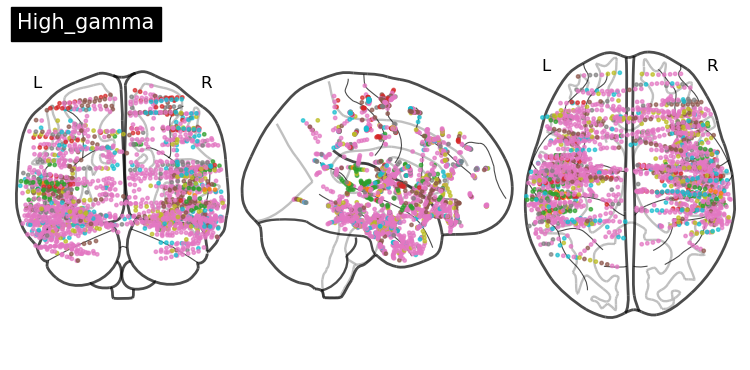

In [78]:
band = 'high_gamma'
colors_w0 = [base_cmap(i) for i in np.unique(labels[band])]
custom_cmap_w0 = ListedColormap(colors_w0, name=f'tab20_{len(np.unique(labels[band]))}')
idx = np.where(labels[band] !=4 )[0]
fig = plotting.plot_markers(node_coords=coord_array[idx],node_values=labels[band][idx],node_size=6,node_cmap=custom_cmap_w0,title=band.capitalize(),display_mode='ortho', colorbar=False)


## TIME SERIE ANALYSIS

In [79]:
# Compo analysis 
nb_compo=3
grp_TS=pd.read_csv(f'{OUT_PATH}/grpPCA/supsubj_concat/grp_concat_Xtrans_PCA{nb_compo}.csv').drop(columns = 'Unnamed: 0')
subj_TS=pd.read_csv(f'{OUT_PATH}/subjPCA/TFR/subj_Xtrans_PCA{nb_compo}_concat.csv').drop(columns = 'Unnamed: 0')
band ="high_gamma"
grp_TS = grp_TS.query("freq == @band")
subj_TS = subj_TS.query("freq == @band")

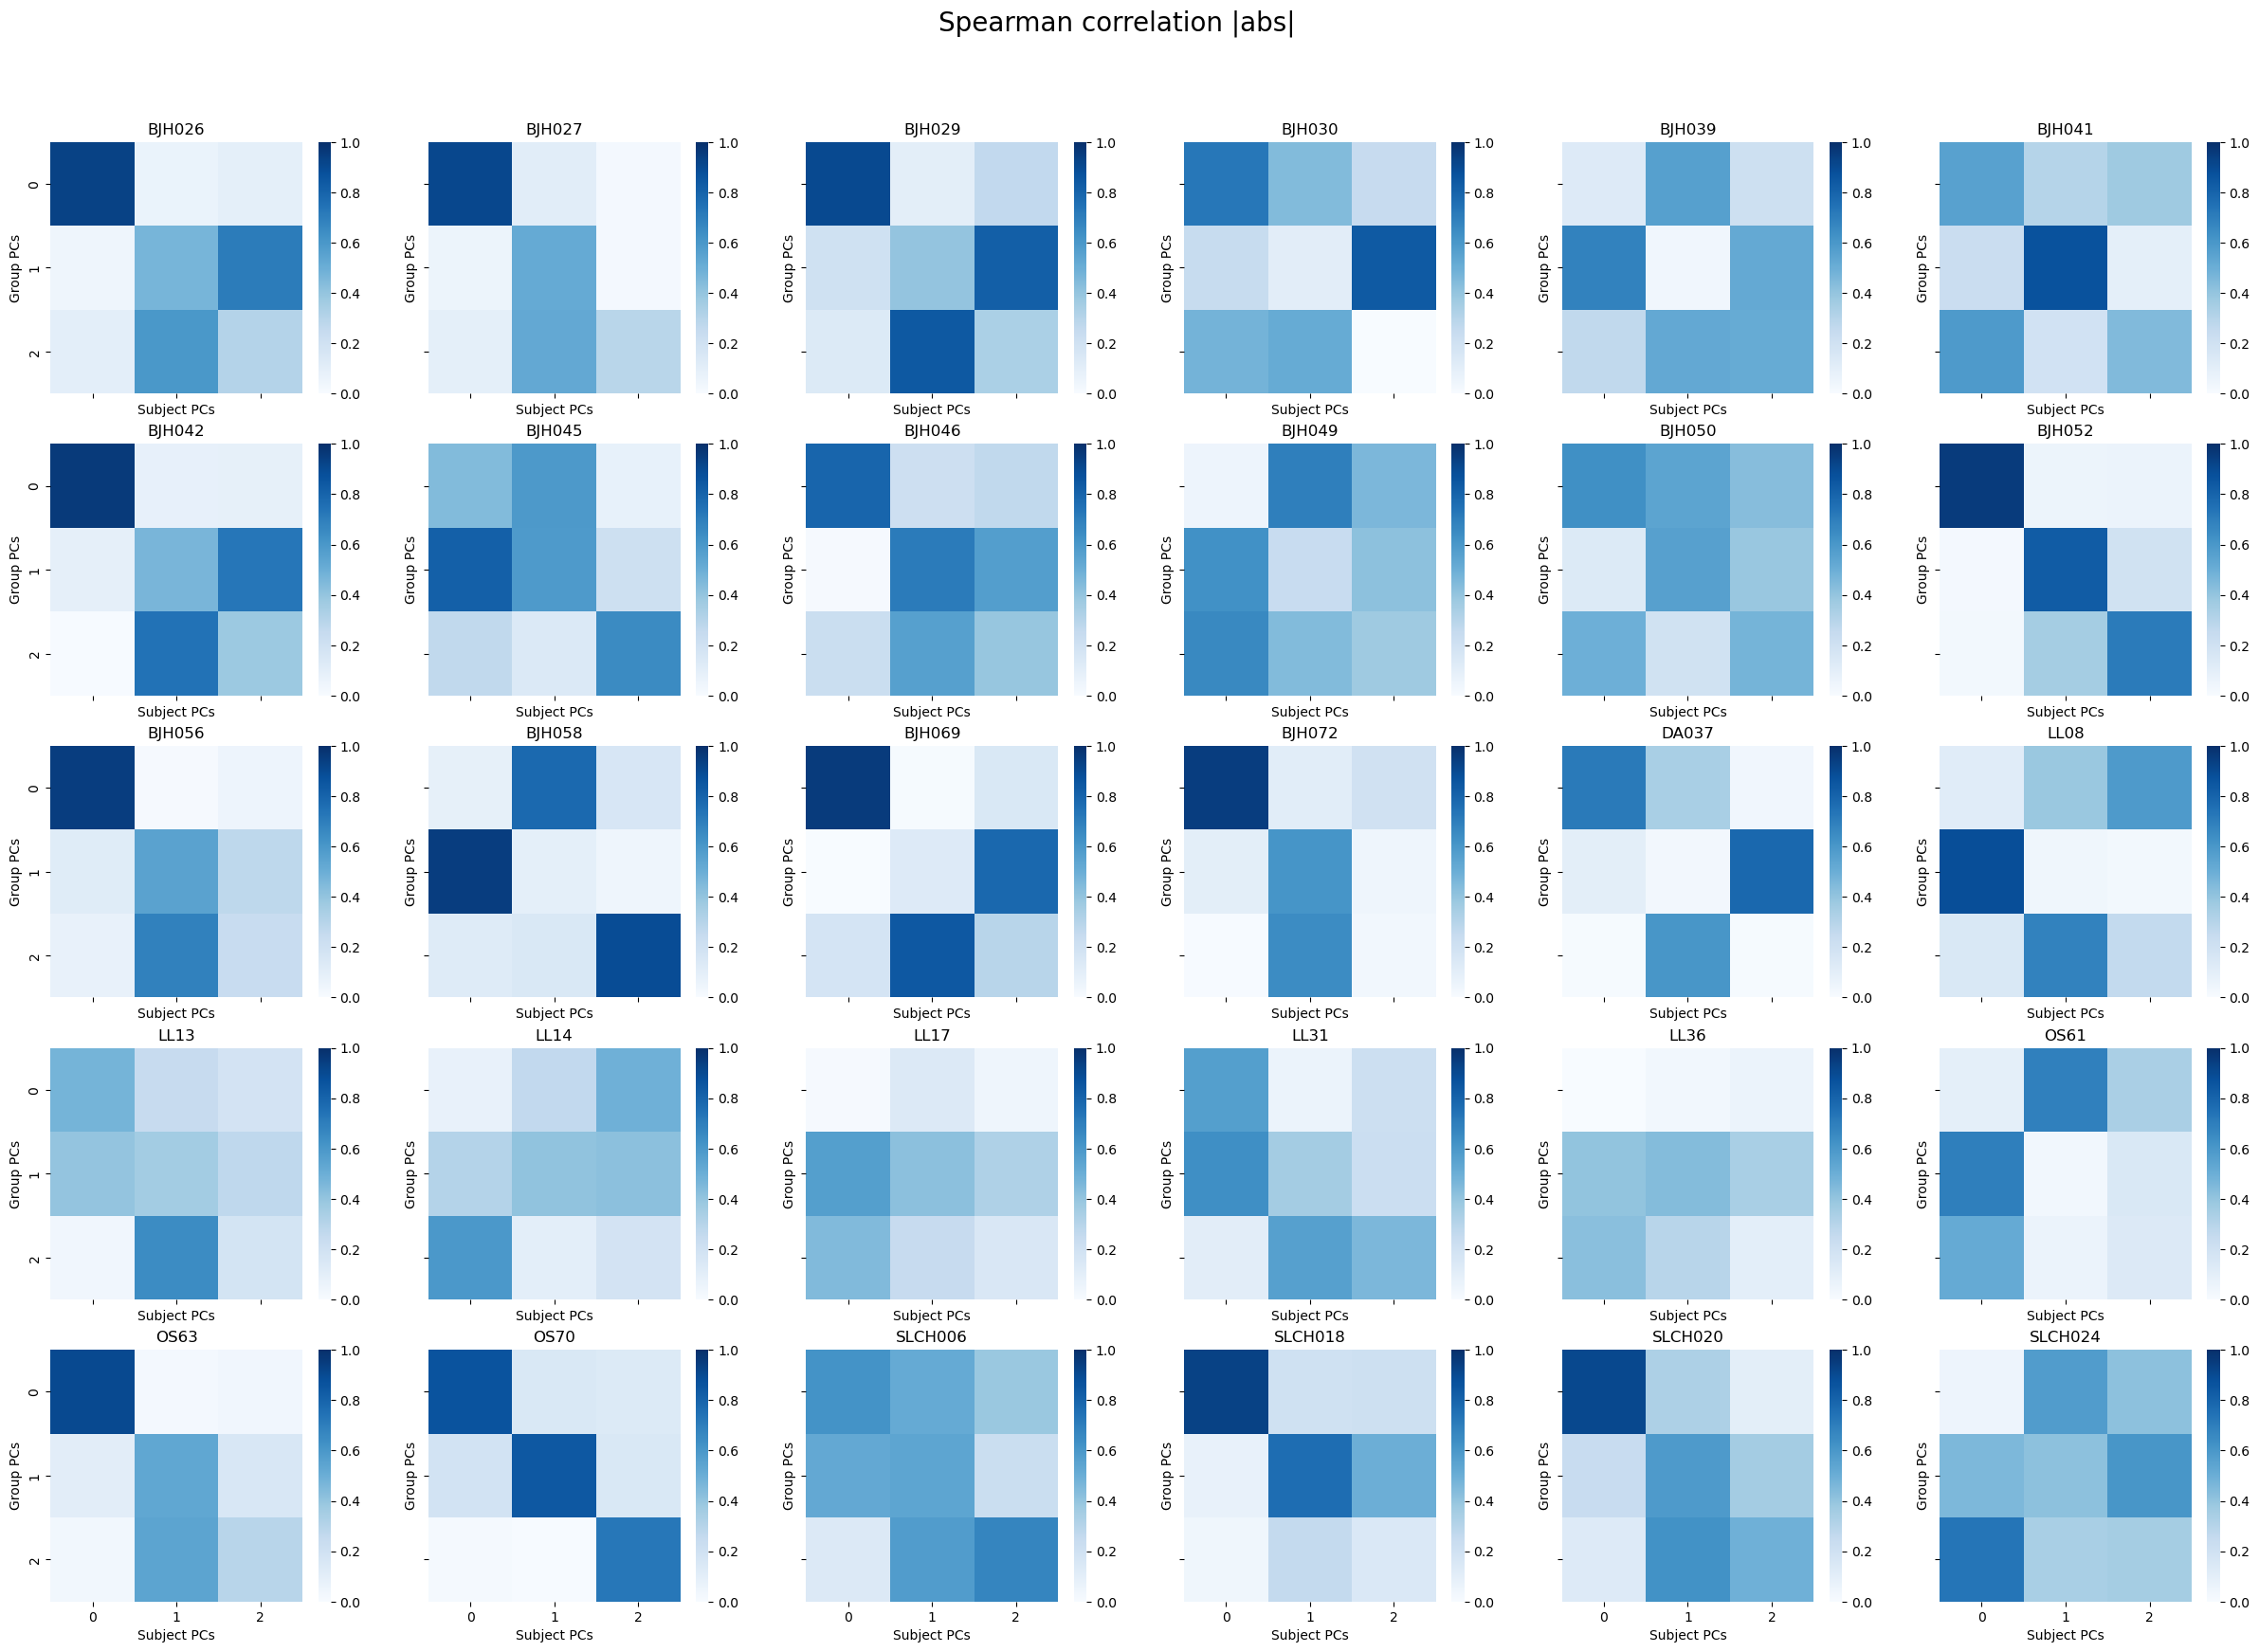

In [80]:
# Correlation table
row_nb = len(np.unique(subj_TS.subj))%5
if row_nb == 0 : row_nb = 5 
col_nb = int(len(np.unique(subj_TS.subj))/5)
if col_nb == 0 : col_nb=1

fig, ax = plt.subplots(row_nb,col_nb, sharey=True, sharex=True, figsize = (col_nb*5, row_nb*4))
fig.suptitle('Spearman correlation |abs|', y=0.95, size = 20)
index_col = grp_TS.columns[-5]


for a, subj in zip(ax.flatten(), np.unique(subj_TS.subj)) : 
    subj_df = subj_TS.query('subj == @subj')
    corr= spearmanr(grp_TS.loc[:, :index_col].T, subj_df.loc[:, :index_col].T)[0][:nb_compo, nb_compo:nb_compo*2]
    sns.heatmap(abs(corr), ax=a, cmap='Blues', vmax = 1, vmin= 0)
    a.set_xlabel('Subject PCs')
    a.set_ylabel('Group PCs')
    a.set_title(subj)
plt.show() 

In [81]:
# built up catergories 
# make categories according to correlation
cat_1 = [] # Cat 1 -- correlation compo 0 - compo 0 
cat_2 = [] # Cat 2 -- correlation compo 1 or 2 -- Noise 
cat_3 = [] # Cat 3 -- correlation main compo latter in subjPC
cat_4 = [] # non of them 

for a, subj in zip(ax.flatten(), np.unique(subj_TS.subj)) : 
    subj_df = subj_TS.query('subj == @subj')
    corr= spearmanr(grp_TS.loc[:, :'321'].T, subj_df.loc[:, :'321'].T)[0][:nb_compo, nb_compo:nb_compo*2]

    if abs(corr[0][0]) >= 0.7 : 
        cat_1.append(subj)
        continue # if highly correlate with the 1 componant do not enter in any other condition 

    if any(abs(corr[0,:]) >= 0.6) :
        cat_3.append(subj) # if correlate with the 1 of the picks componant do not enter in any other condition 
        continue

    if any(abs(corr[1][:]) >= 0.6) or any(abs(corr[2][:]) >= 0.6) : 
        cat_2.append(subj) # correlate with noisy componant

    if subj not in cat_2 and subj not in cat_3 : 
        cat_4.append(subj) # others

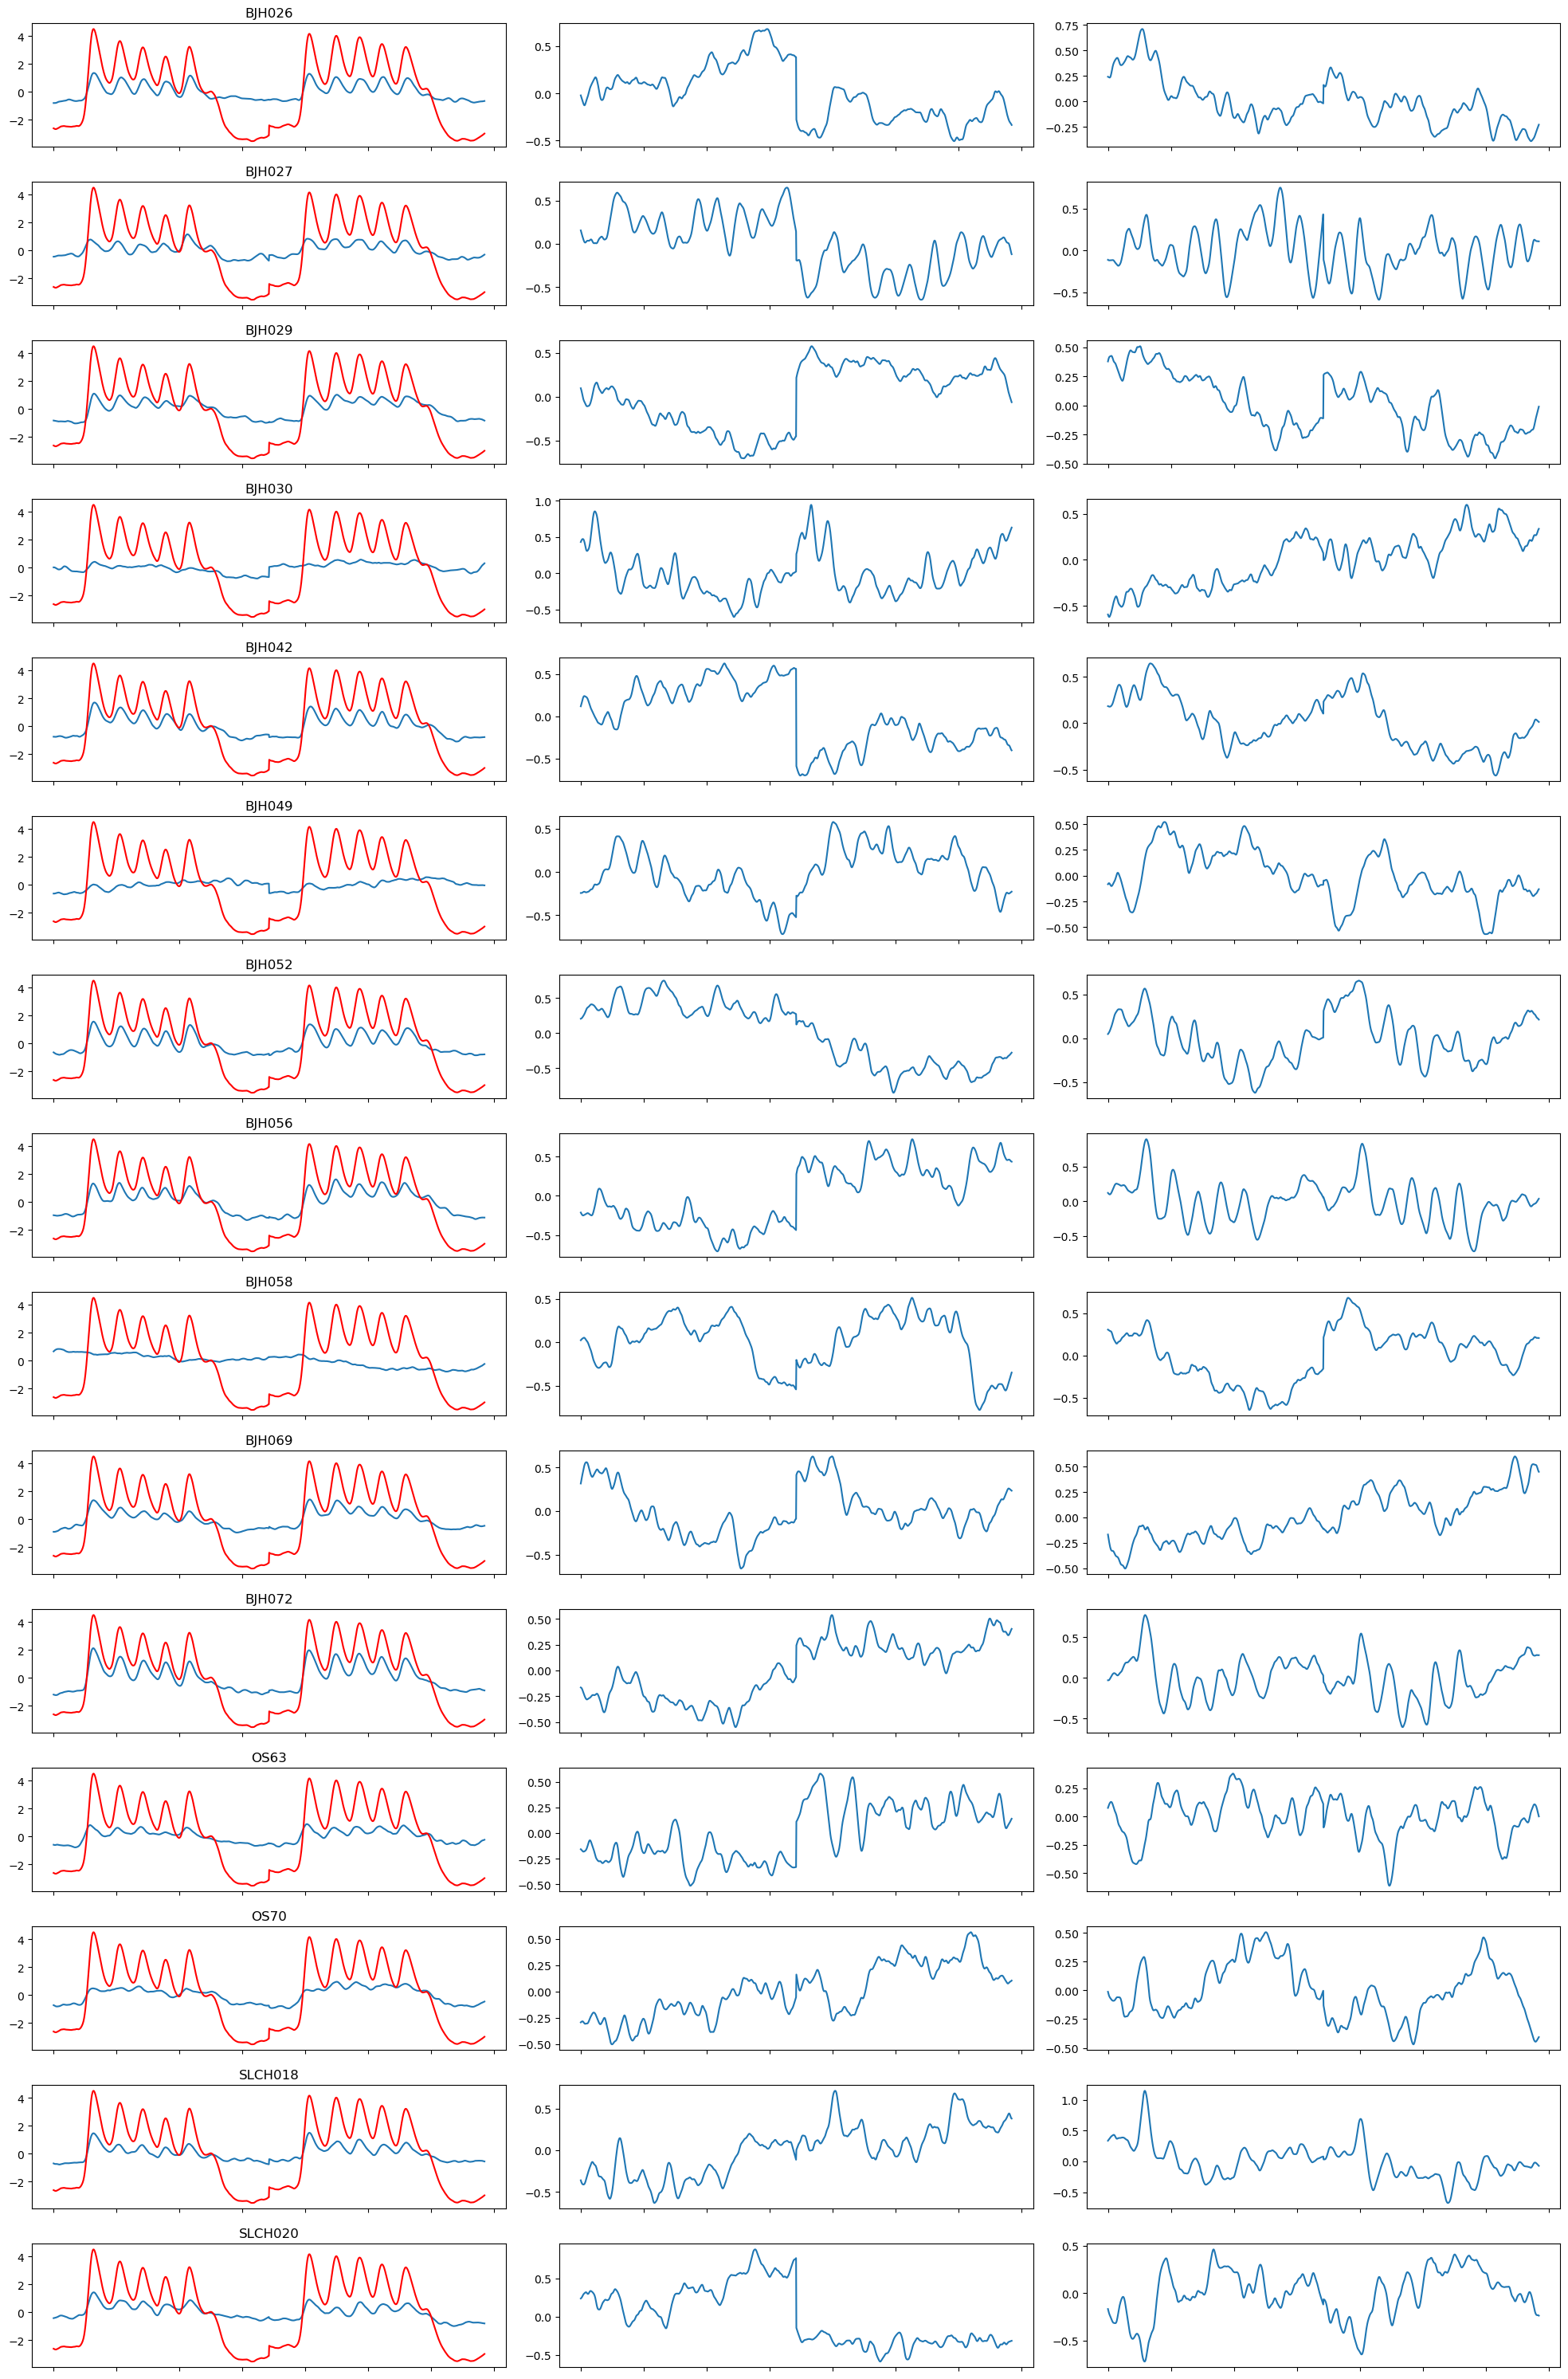

In [82]:
# Get the time series with overlapping correlated grp compo
cat = cat_1
fig, ax=plt.subplots(len(cat), nb_compo, figsize = (20, 2*len(cat)))
fig.tight_layout()

for i, subj in enumerate(cat) : 
    if len(cat) == 1 : 
        the_ax = ax
    else : the_ax = ax[i]

    # get the time 
    info_file = f'{OUT_PATH}/Data/{subj}_info.json'
    with open(info_file) as f:
        info = json.load(f)
        time = info['time_tfr']
        
    subj_df = subj_TS.query('subj == @subj').set_index('compo')
    
    for j in range(nb_compo) : 
        the_ax[j].plot(subj_df.loc[f'compo{j+1}', :index_col].values)
        the_ax[j].set_xticklabels([])
    the_ax[0].plot(grp_TS.set_index('compo').loc['compo1', :index_col].values, color = 'red')
    the_ax[0].set_title(subj) 